# Introduction
---

## Data Set Information

The problem includes 5 datasets, each of them defining a different learning problem:

* LP1: failures in approach to grasp position
* LP2: failures in transfer of a part
* LP3: position of part after a transfer failure
* LP4: failures in approach to ungrasp position
* LP5: failures in motion with part

## Attribute Information

All features are numeric although they are integer valued only. Each feature represents a force or a torque measured after failure detection; each failure instance is characterized in terms of **15 force/torque samples** collected at regular time intervals starting immediately after failure detection. *The total observation window for each failure instance was 315 ms*.

Each example is described as follows:

**class**\
Fx1 Fy1 Fz1 Tx1 Ty1 Tz1\
Fx2 Fy2 Fz2 Tx2 Ty2 Tz2\
......\
Fx15 Fy15 Fz15 Tx15 Ty15 Tz15

where Fx1 ... Fx15 is the evolution of force Fx in the observation window, the same for Fy, Fz and the torques; there is a **total of 90 features**.

---
---
# Imports

In [1]:
# Timer
import time

# Importing OS module
import sys

# Data-processing function
from data_processing import process_data, class_dist, graph_observations, build_model

# Data-processing libraries
import pandas as pd
from glob import glob
import re

# Linear Algebra
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# SKLearn Algorithms
import sklearn as sk
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
# SVC
from sklearn.svm import SVC
# Test-train split
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
# Accuracy metric
from sklearn.metrics import accuracy_score

from sklearn.model_selection import RandomizedSearchCV

# Data Noramlisation
from sklearn.preprocessing import StandardScaler
# PCA
from sklearn.decomposition import PCA

# Tensorflow (NN)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
tf.random.set_seed(42)

# Epoch plotting
from plot_keras_history import plot_history

# XGBoost Classifier
import xgboost as xgb

# SMOTE
from imblearn.over_sampling import SMOTE

# Stats
from scipy import stats

# Set random seed for reproducibility
np.random.seed(0)
sns.set()  # Stylises graphs

In [45]:
import sys
import matplotlib
import scipy
import sklearn
import imblearn

print(f"Python version: {sys.version}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}") 
print(f"scikit-learn version: {sklearn.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"imblearn version: {imblearn.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"xgboost version: {xgb.__version__}")

Python version: 3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]
pandas version: 1.1.0
matplotlib version: 3.3.0
NumPy version: 1.19.5
SciPy version: 1.5.2
scikit-learn version: 0.24.0
Seaborn version: 0.11.1
imblearn version: 0.7.0
Tensorflow version: 2.4.0
xgboost version: 1.3.1


---
---
# Data Processing

The below transforms the .data files provided into a format that is readable using the `process_data` function in `data_processing.py`

In [3]:
# Calling the process_data function from data_processing.py
lp1 = process_data('./Dataset/lp1.data')
lp2 = process_data('./Dataset/lp2.data')
lp3 = process_data('./Dataset/lp3.data')
lp4 = process_data('./Dataset/lp4.data')
lp5 = process_data('./Dataset/lp5.data')

---
## Reading in the Data

In [4]:
# Checking that the lengths of each dataset are correct
print(f'LP1 Length: {len(lp1)}/88')
print(f'LP2 Length: {len(lp2)}/47')
print(f'LP3 Length: {len(lp3)}/47')
print(f'LP4 Length: {len(lp4)}/117')
print(f'LP5 Length: {len(lp5)}/164')

if (
    len(lp1) == 88 and
    len(lp2) == 47 and
    len(lp3) == 47 and
    len(lp4) == 117 and
    len(lp5) == 164
):
    print('\nAll Datasets are complete.')

LP1 Length: 88/88
LP2 Length: 47/47
LP3 Length: 47/47
LP4 Length: 117/117
LP5 Length: 164/164

All Datasets are complete.


---
## Null Values

Each dataset will be checked to see if any null rows are present, if they are then they will be removed from the datasets.

In [5]:
# Checking for any null values across the datasets
print(f'Number of missing values in lp1: {sum(lp1[lp1.columns].isnull().sum())}')
print(f'Number of missing values in lp2: {sum(lp2[lp2.columns].isnull().sum())}')
print(f'Number of missing values in lp3: {sum(lp3[lp3.columns].isnull().sum())}')
print(f'Number of missing values in lp4: {sum(lp4[lp4.columns].isnull().sum())}')
print(f'Number of missing values in lp5: {sum(lp5[lp5.columns].isnull().sum())}')

Number of missing values in lp1: 0
Number of missing values in lp2: 0
Number of missing values in lp3: 0
Number of missing values in lp4: 0
Number of missing values in lp5: 0


Since no null values are present, no rows or columns need to be removed.

---
## Duplicated Values

The datasets will now be checked for any duplicated rows.

In [6]:
# Checking for any duplicated values across the datasets
print(f"Duplicates in LP1: {lp1.duplicated().sum()}")
print(f"Duplicates in LP2: {lp2.duplicated().sum()}")
print(f"Duplicates in LP3: {lp3.duplicated().sum()}")
print(f"Duplicates in LP4: {lp4.duplicated().sum()}")
print(f"Duplicates in LP5: {lp5.duplicated().sum()}")

Duplicates in LP1: 0
Duplicates in LP2: 1
Duplicates in LP3: 1
Duplicates in LP4: 1
Duplicates in LP5: 1


There appears to be 1 duplicated row in each dataset apart from LP1, this will be investigated further.

In [7]:
# Checking duplicated rows for LP2
print("Duplicates for LP2: ")
lp2[lp2.duplicated(keep=False)]

Duplicates for LP2: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
44,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,back_col
45,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,back_col


In [8]:
# Checking duplicated rows for LP3
print("Duplicated rows for LP3: ")
lp3[lp3.duplicated(keep=False)]

Duplicated rows for LP3: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
44,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,slightly_moved
45,-12.0,-20.0,109.0,27.0,-44.0,-14.0,-17.0,-10.0,82.0,14.0,...,14.0,0.0,2.0,3.0,5.0,77.0,-12.0,3.0,-2.0,slightly_moved


In [9]:
# Checking duplicated rows for LP4
print("Duplicated rows for LP4: ")
lp4[lp4.duplicated(keep=False)]

Duplicated rows for LP4: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
24,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision
44,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision


In [10]:
# Checking duplicated rows for LP5
print("Duplicated rows for LP5: ")
lp5[lp5.duplicated(keep=False)]

Duplicated rows for LP5: 


,Fx0,Fy0,Fz0,Tx0,Ty0,Tz0,Fx1,Fy1,Fz1,Tx1,...,Tx13,Ty13,Tz13,Fx14,Fy14,Fz14,Tx14,Ty14,Tz14,label
71,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision_in_part
91,-15.0,22.0,123.0,-98.0,1.0,-15.0,29.0,19.0,13.0,23.0,...,-5.0,1.0,-4.0,-6.0,5.0,3.0,-7.0,1.0,-3.0,collision_in_part


As can be seen from the above, these duplicated rows in the datasets are exact copies of eachother. With such a small dataset and over 90 variables being measured, it is extremely unlikely that these are substantial and could skew the distribution of the classes when making the model.

These are most likely due to some kind of logging/data-collection error, so the second occurence for each duplicate will be removed from the datasets.

In [11]:
# Removing duplicates except for the first occurence
lp1 = lp1.drop_duplicates()
lp2 = lp2.drop_duplicates()
lp3 = lp3.drop_duplicates()
lp4 = lp4.drop_duplicates()
lp5 = lp5.drop_duplicates()

---
---
# Exploratory Data Analysis (EDA)

The data takes the form shown below, where each column represents a force or torque in one of the 3-coordinate axis (X, Y, Z) across the 15 time-steps as previously discussed.
```
normal
	-1	-1	63	-3	-1	0
	0	0	62	-3	-1	0
	-1	-1	61	-3	0	0
	-1	-1	63	-2	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	63	-3	0	0
	-1	-1	63	-3	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	61	-3	0	0
	-1	-1	61	-3	0	0
	-1	-1	64	-3	-1	0
	-1	-1	64	-3	-1	0
	-1	-1	60	-3	0	0
	-1	0	64	-2	-1	0


normal
	-1	-1	63	-2	-1	0
	-1	-1	63	-3	-1	0
	-1	-1	61	-3	0	0
	0	-4	63	1	0	0
	0	-1	59	-2	0	-1
	-3	3	57	-8	-3	-1
	-1	3	70	-10	-2	-1
	0	-3	61	0	0	0
	0	-2	53	-1	-2	0
	0	-3	66	1	4	0
	-3	3	58	-10	-5	0
	-1	-1	66	-4	-2	0
	-1	-2	67	-3	-1	0
	0	1	66	-6	-3	-1
	-1	-1	59	-3	-4	0
```

Before models can be effectively made for the 5 datasets, some initial EDA will be performed on the datasets to determine if there are any clear indicators for a certain classification.

For each classification in each dataset, the values of force and torque will be investigated to look for any corellation.

---
## Class Distribution

The class distribution for each dataset is shown below:

-- **LP1**: 24% normal,
           19% collision, 
           18% front collision,
           39% obstruction

   -- **LP2**: 43% normal,
           13% front collision,
           15% back collision,
           11% collision to the right,
           19% collision to the left

   -- **LP3**: 43% ok,
           19% slightly moved,
           32% moved,
            6% lost

   -- **LP4**: 21% normal,
           62% collision,
           18% obstruction

   -- **LP5**: 27% normal,
           16% bottom collision,
           13% bottom obstruction,
           29% collision in part,
           16% collision in tool


The frequency of each class across the datasets will be graphed below using the `class_dist` function in `data_processing.py`

In [12]:
# Setting a name for each dataset
lp1.name = 'LP1'
lp2.name = 'LP2'
lp3.name = 'LP3'
lp4.name = 'LP4'
lp5.name = 'LP5'

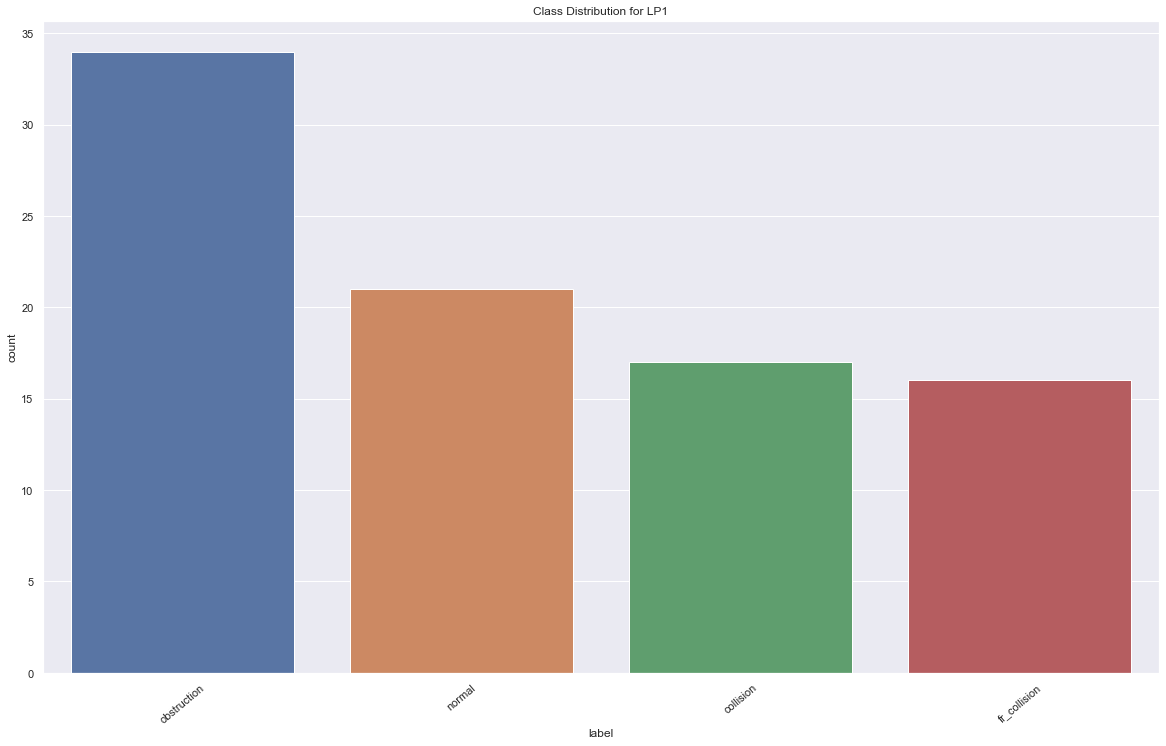

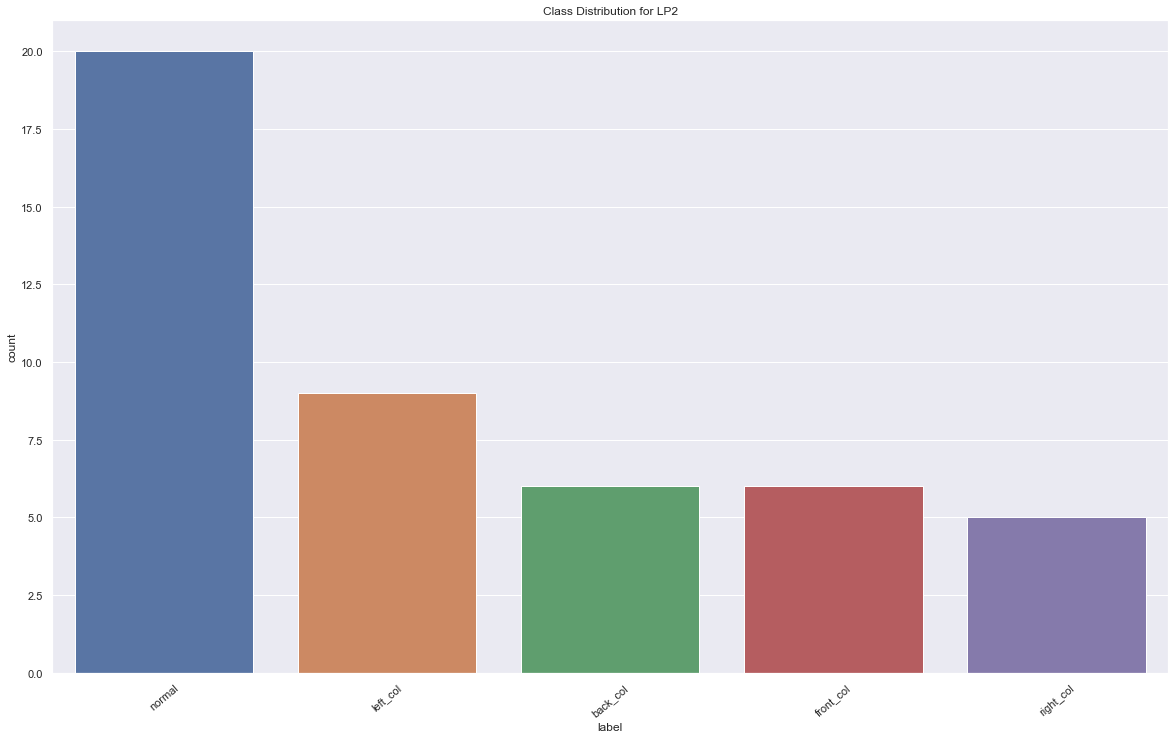

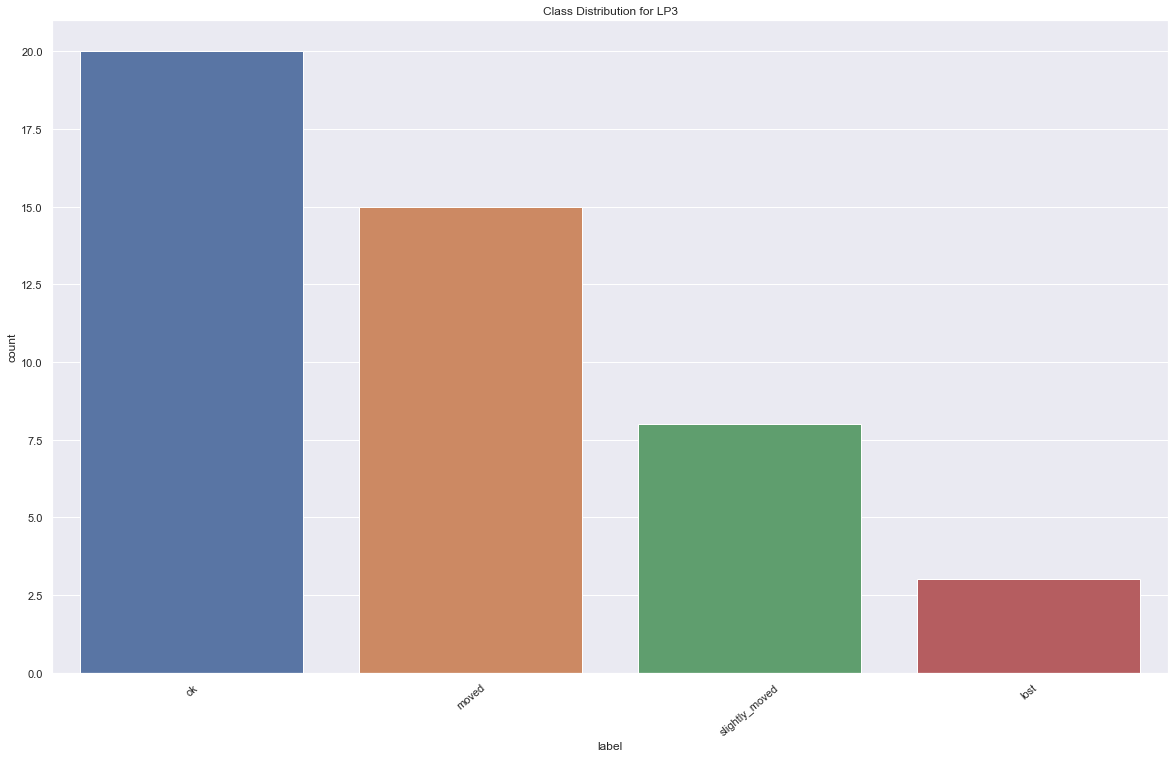

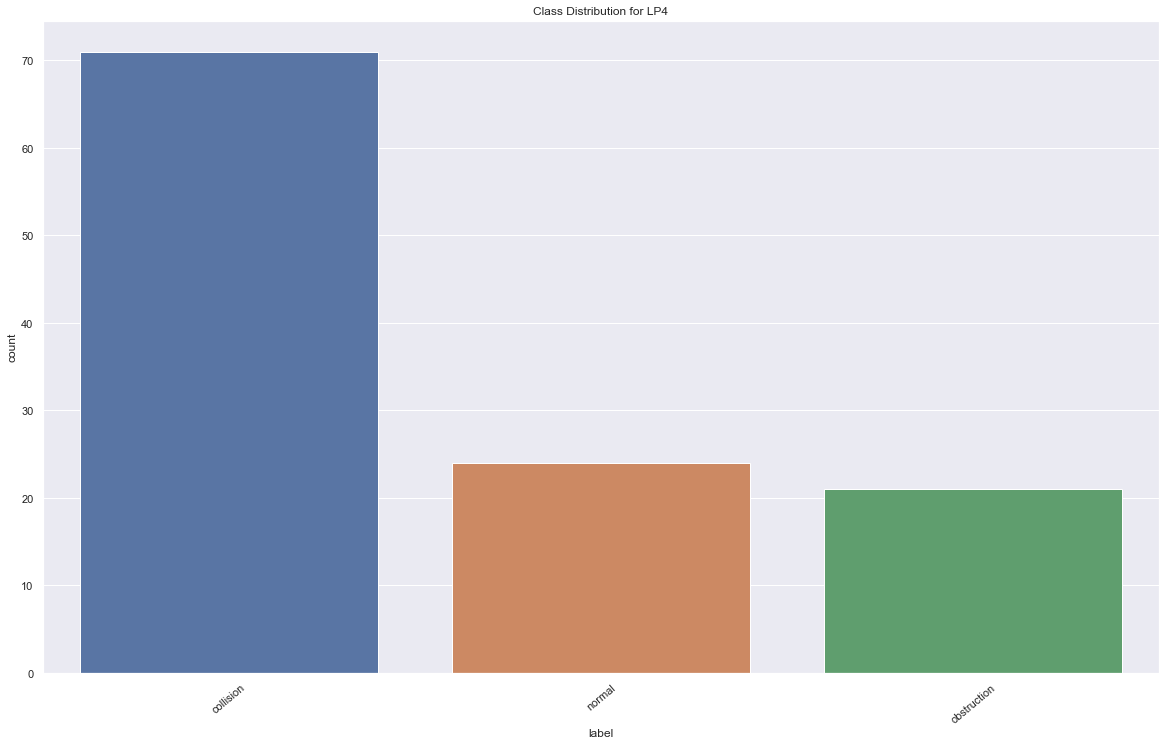

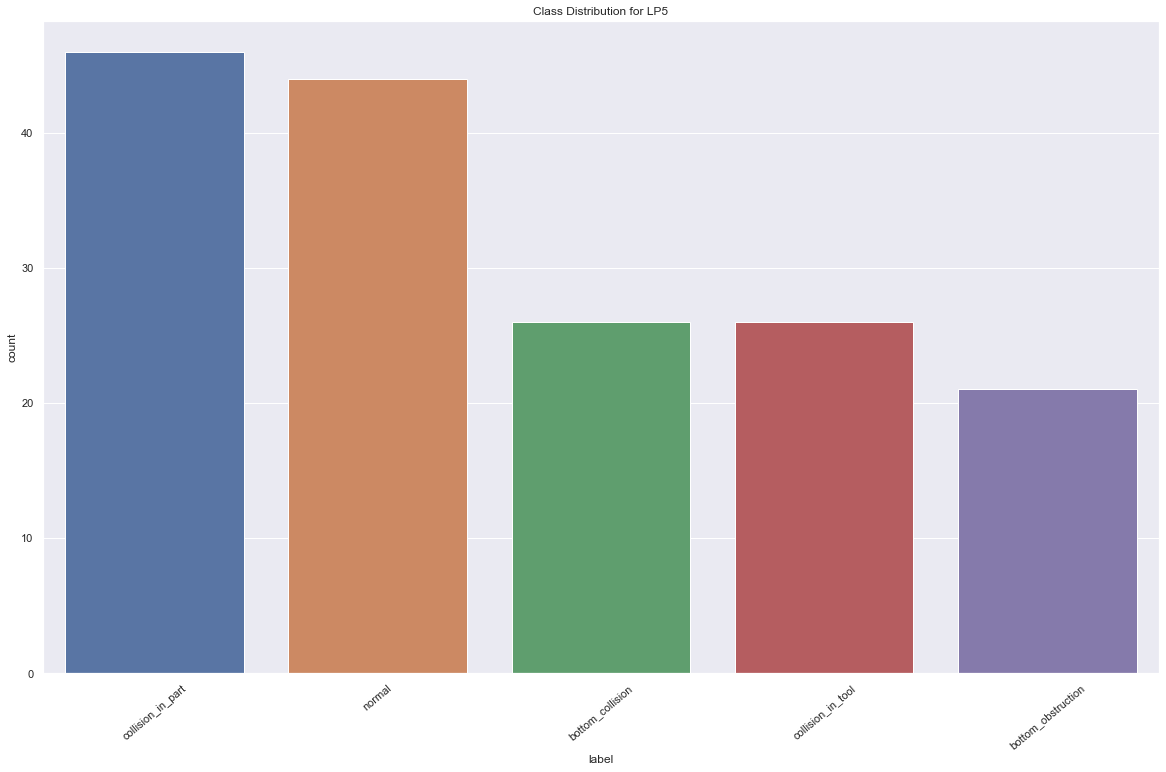

In [13]:
# Calling the class_dist function for each dataset
class_dist(lp1)
class_dist(lp2)
class_dist(lp3)
class_dist(lp4)
class_dist(lp5)

### Observations on Class Distribution

As can be seen from the above graphs, the classes are not evenly distributed. This could be extremely problematic when model building as it could create false levels of accuracy in the models.

The most problematic of these is the **'lost'** classification in LP3, having only 3 occurrences. If the dataset was split 80/20 training/testing, the testing dataset may not contain any **'lost'** classifications at all.

Also, if there is an extremely high distribution of one specific class, the model will likely overestimate it's accuracy. 

For example: If a dataset has 2 classes with distributions of 99% and 1% respectively, the model could predict the class with a distrubition of 99% for every classification and achieve an accuracy of 99%. When tested in a real world scenario, the model may perform extremely poorly as it will predict the 99% class every time; this will happen if the distribution of classes in the real world is not the same as in the dataset.

To solve these class imbalances there are several techniques that could be implemented, namely **Random Oversampling**, **Random Undersampling** and **SMOTE**. For this problem, **SMOTE** will be applied to the datasets to attempt to give more accurate results of the models.

---
## Force Type vs Time(ms)


A function was created in `data_processing.py` that automatically creates graphs for the selected dataset of the selected force type against time for all classifications in that dataset. The inputs are as follows: 
* **observation_types**: The classifications for the dataset (Automatically created, only the 'lpi' value needs to be changed, where i is the dataset number).
* **df**: The desired Dataset (lp1, lp2, lp3, lp4, lp5).
* **force**: The desired force type (Fx, Fy, Fz, Tx, Ty, Tz)

Plotting these graphs is important as it allows for better understanding of what the parameters look like for a given dataset, allowing for better models to be created.

Plotting all combinations for each dataset would result in 30 subplots of graphs, to make the file more readable only one subplot of graphs will be displayed with instructions on how to change the displayed subplots. To find all the subplots please refer to **Appendix** in the report file.

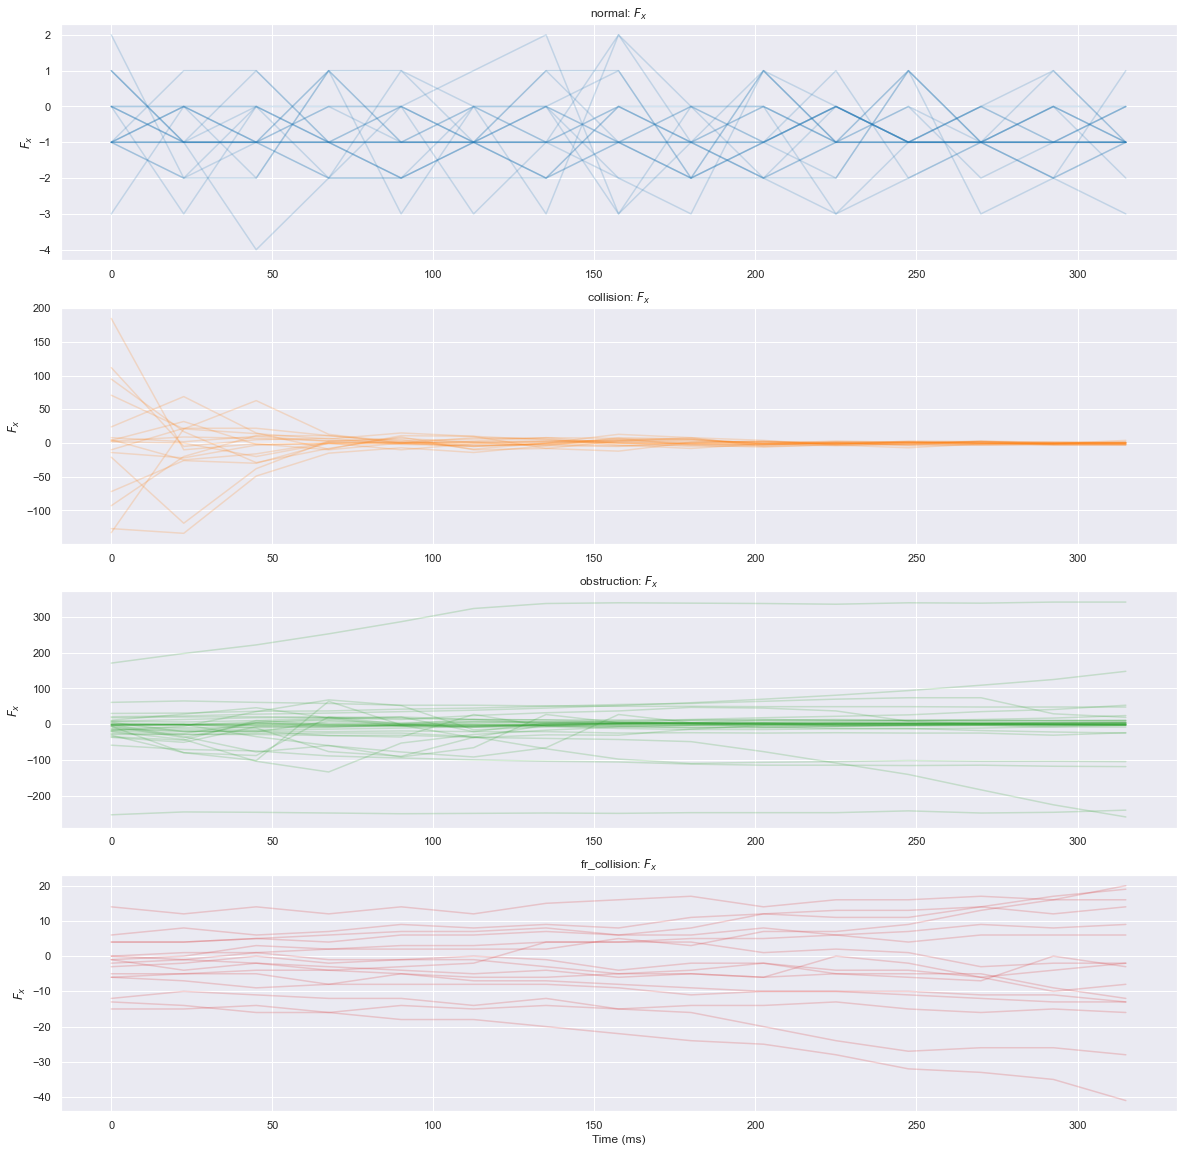

In [14]:
# Defining which classifications should be used
# To change the dataset, change the 'i' in 'lpi' in the line "observation_types = lpi['label'].unique()"
# Where i is the dataset number
observation_types = lp1['label'].unique()

# Calling the graph_observations function from data_processing.py
graph_observations(
    # Defines which dataset should be used, to change the dataset change df = lpi, where i is the dataset number
    df=lp1,
    # Defines the observation types, as classified above
    observation_types=observation_types,
    # Defines the force to be plotted out of, Fx, Fy, Fz, Tx, Ty, Tz
    force='Fx'
)

### Observations

Even from this one subplot, there are a few observations that can be made. 

The first observation from this subplot is that the $F_x$ values for the **'normal'** class vary significantly less than the other classifications over time, with a range of: **2 $\ge$ $F_x$ $\ge$ -4**. If the graph for the **'normal'** class shared a similar sized y-axis to the other classifications, it would appear as a thick straight line of approximately **y = 0**.

The $F_x$ values for the **'collision'** class are clearly significantly different. With a general trend of the 1st, 2nd or 3rd datapoints being extremely high or low, before tending towards a value of **y = 0**.

The $F_x$ values for the **'obstruction'** class are harder to draw conclusions from, however they still display a significantly different trend than the other classifications. Similar to the **'collision'** class, the values tend towards a value of **y = 0** at the end of the time-steps. However, there is more variation in the data between the beginning and end of the time-steps than in the **'collision'** class. $F_x$ may not be the best parameter to determine an **'obstruction'** class.

The $F_x$ values for the **'fr_collision'** class show much less variation in values than both the **'collision'** and **'obstruction'** classes but significantly more variation than the **'normal'** class. The values appear to be more static over the time-steps than either the **'collision'** or **'obstruction'** classes.

From just this one subplot many observations can be drawn which would help with model building. If this was done for all subplots across each dataset it could help in determining some parameters that could be removed using dimensionality reduction techniques. As the datasets are required to be organised in a high-dimensional space to create models, they may suffer some statistical phenomena due to the **Curse of Dimensionality**. Performing dimensionality reduction could help alleviate some of these issues.

---
---
# Model Building

The model building section is split up separately for each dataset. Before any models are built, a brief overview of each model that is being used will be given as shown below.

## Random Forest Classification
Random Forest Classification isa  decision-tree machine-learning technique consisting of a large number of individual trees operating as an ensemble. The trees that are constructed are given a random subset of parameters from the overall data. Each tree in the random forest produces a classification prediction; The classification with the most predictions is chosen as the overall output of the model.

## XGBoost Classification
XGBoost is another decision-tree machine-learning technique that utilises gradient boosting. Gradient boosting is the application of a gradient descent algorithm to minimise the errors present in each sequential model produced. XGBoost takes this a step further and introduces parallel processing, tree-pruning and regularisation to avoid model overfitting or bias.

## K-Nearest Classification
KNN works by looking at the given set of parameters and comparing them to their 'neighbors' based on the distance between the points on a graph. The amount of neighbors is specified, then the data that is to be predicted is compared to other data entries that are closest on a graph (with the amount of data points assessed being the amount of neighbors). Out of these neighbors, the most frequently occuring classifcation will be assigned as the prediction.

## Naive Bayes
Naive Bayes is a probabilistic algorithm, where based on given parameters the probability of it being a certain classification is assessed; the classificaiton with the highest probability is predicted. Naive Bayes assumes that all given parameters are independent of eachother, hence the term 'Naive'. This allows for classification to be done with much fewer parameters, changing the number of parameters from $2^k$ to $k$. As such, Naive Bayes is renowned for handling high-dimensional data well.

## SVM - Linear Kernel
SVMs attempt to find a hyperplane (or hyperplanes) that divides a dataset into the relevant classifications. It uses a kernel function to transform the data into a higher dimension. Based on where the given set of parameters lie relative to the hyperplane, a classification is given; with more confidence being given to the classification the further away the given data is from the hyperplane. Two SVMs have been used in this project using different kernel functions.

## SVM - RBF Kernel
This SVM is as explained above, but utilises the RBF Kernel.

## Artificial Neural Network - Feed Forward
A neural network is an attempt at replicating the function of neurons inside the human brain. It consists of three types of layers: The input layer, output layer and hidden layers. The input layer contains the input paramaters to the problem. The output layer contains the output (classification) of the neural network from the given inputs. The hidden layers contain interconnected processing nodes where data is transferred down the network towards the output layer. Each node is assigned a weight value and when data is received it multiplies that data by the associated weight value. If this value is above a set threshold the neuron activates and sends the data further up the network along all of its connections. When a neural network is initialised, the weights and thresholds for each node are randomly generated. During the training process, the weight and threshold values for each node are automatically adjusted to minimise the error of the network.

---

## Data Encoding

Before models can be constructed, the datasets must be encoded as only numerical data can be read by the models.

This section will encode the original datasets and store them in dictionaries. The encoding will be done using two methods:

* **Multi-class**: Where the original classes from the dataset are kept and encoded using OneHotEncoding.
* **Binary-class**: Where the classes are converted to a binary problem, with 'normal' or 'ok' classifications being considered 1 and all 'failure' classifications being considered 0.

Since the datasets are so small, simplifying the problem to a binary classification may improve the results achieved. However, the specific failure classification can no longer be determined.

Below, a list of the datasets is created to be iterated over and the dictionaries are setup to store the encoded datasets.

In [15]:
# Creating a list of all the datasets
datasets = [lp1, lp2, lp3, lp4, lp5]

# Creating a dictionary for multi-class classification
multi_class_datasets = {
    'output_cols': [],
    'input_cols': [],
    'datasets': []
}

# Creating a dictionary for binary-class classification
binary_class_datasets = {
    'output_cols': [],
    'input_cols': [],
    'datasets': []
}

### Multi-Class Encoding - OneHotEncoding (OHE)

This section encodes the datasets using OneHotEncoding where $n$ columns are added to the dataset, with: 

$n$ = Number of classification types

The new columns contain a 0 or 1 to determine the presence or absence of that classification.

**OneHotEncoding** is used in this instance instead of **Label Encoding**. When using multiple classifications in **Label Encoding**, each classification is given an integer value based on their alphabetical ordering. As such, the classification that comes last in the alphabetical ordering will be given a higher integer value. This can cause the model to falsely determine a relationship between the classifications such that:

*Last Classification Alphabetically*  $>$  *First Classification Alphabetically*

In [16]:
# Iterates over all datasets in datasets[]
for dataset in datasets:
    # Prevents the datasets being iterated over too many times
    if len(multi_class_datasets['datasets']) >= 5:
        print('Encoding has already been run.')
        print('If you wish to alter the dataset, please re-run the notebook or the cell above.')
        break
    else:
        # Creating copies of the datasets, stops it editing the
        # original dataset
        dataset = dataset.copy()
        # Using OneHotEncoding on the 'label' column
        multi_labels = pd.get_dummies(dataset['label'])
        # Setting the output column names (?)
        output_cols = multi_labels.columns
        # Appending the input columns to the dictionary
        multi_class_datasets['input_cols'].append(
            dataset.drop('label', axis=1).columns
        )
        # Adding the encoded labels to the dataset
        dataset[output_cols] = multi_labels
        # Appending the output columns to the dictionary
        multi_class_datasets['output_cols'].append(output_cols)
        # Removing the old label column from the dataset
        dataset = dataset.drop('label', axis=1)
        # Appending the encoded dataset to the dicitionary
        multi_class_datasets['datasets'].append(dataset)

### Binary-Class Encoding - Label Encoding

In [17]:
# Iterates over all datasets in datasets[]
for dataset in datasets:
    # Prevents the datasets being iterated over too many times
    if len(binary_class_datasets['datasets']) >= 5:
        print('Encoding has already been run.')
        print('If you wish to alter the dataset, please re-run the notebook or the cell above.')
        break
    else:
        # Creating copies of the datasets, stops it editing the
        # original dataset
        dataset = dataset.copy()
        # Appending output columns to the dictionary
        binary_class_datasets['output_cols'].append(['label'])
        # Encoding the data to 1 for 'normal' or 'ok'
        # 0 for all other failure modes
        dataset['label'] = [
            1 if label == 'normal' or label == 'ok' else 0
            for label in dataset['label']
        ]
        # Appending the input columns to the dictionary
        binary_class_datasets['input_cols'].append(
            dataset.drop('label', axis=1).columns
        )
        # Appending the modified dataset to the dictionary
        binary_class_datasets['datasets'].append(dataset)

In [18]:
# MULTI-CLASS
multi_zipped_dict = zip(
    multi_class_datasets['datasets'],
    multi_class_datasets['input_cols'],
    multi_class_datasets['output_cols'],
    ['LP1', 'LP2', 'LP3', 'LP4', 'LP5']
)

In [19]:
# SINGLE-CLASS
binary_zipped_dict = list(zip(
    binary_class_datasets['datasets'],
    binary_class_datasets['input_cols'],
    binary_class_datasets['output_cols'],
    ['LP1', 'LP2', 'LP3', 'LP4', 'LP5']
))

---
## Class Rebalancing - SMOTE

As previously discussed, the datasets being used contain quite severe class imbalances. To aid with model building **SMOTE** will be applied to the datasets. **SMOTE** will be applied inside the `build_model` function in the `data_processing.py` file. **SMOTE** should only be applied to the training dataset to prevent the training dataset containing synthesised values.

A demonstration of **SMOTE** is shown below.

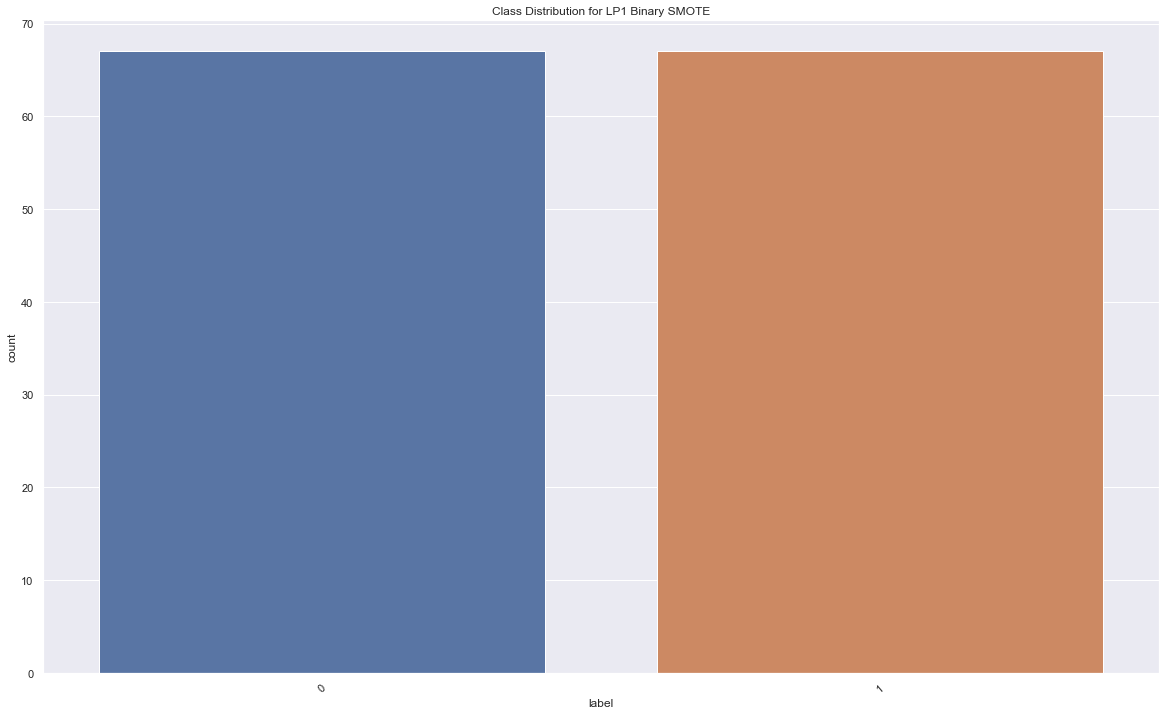

In [20]:
sm = SMOTE(
    random_state=0
)

lp1 = binary_class_datasets['datasets'][0].copy()
lp1_input = binary_class_datasets['input_cols'][0]
lp1_output = binary_class_datasets['output_cols'][0]

X_res, y_res = sm.fit_resample(
    lp1[lp1_input],
    lp1[lp1_output]
)

lp1_res = X_res
lp1_res[lp1_output] = y_res
lp1_res.name = 'LP1 Binary SMOTE'

class_dist(lp1_res)

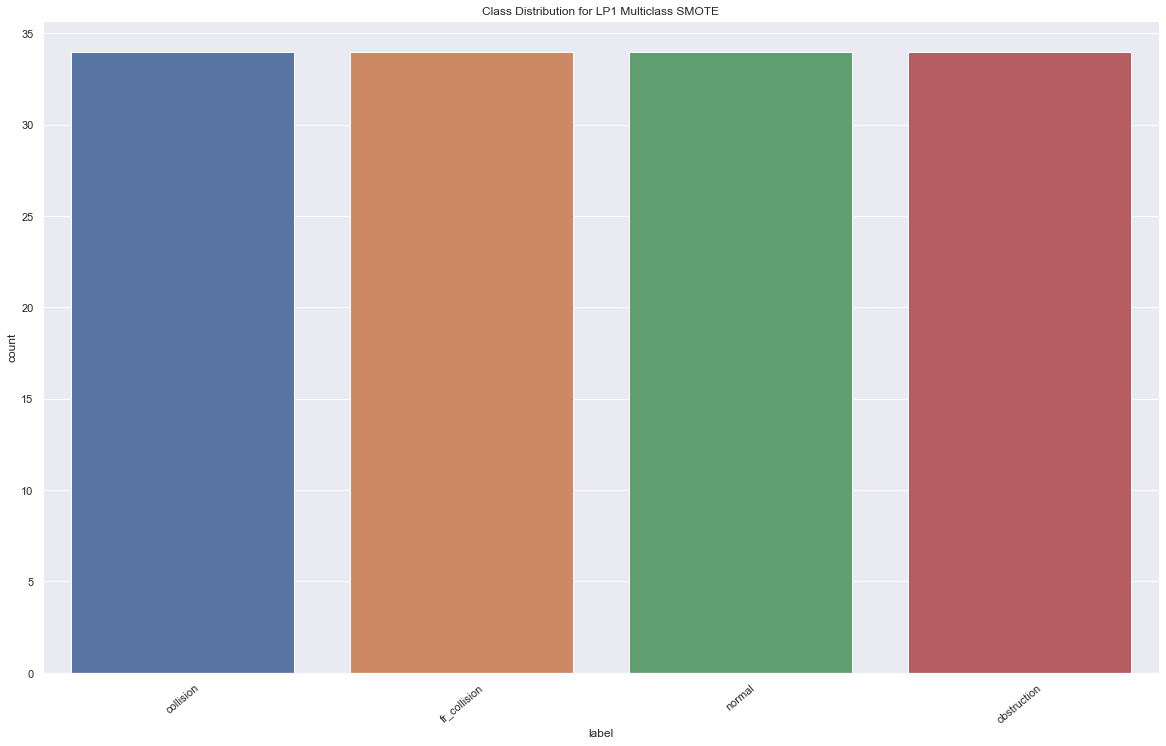

In [21]:
lp1 = multi_class_datasets['datasets'][0].copy()
lp1_input = multi_class_datasets['input_cols'][0]
lp1_output = multi_class_datasets['output_cols'][0]

sm = SMOTE(
    random_state=0
)

X_res, y_res = sm.fit_resample(
    lp1[lp1_input],
    lp1[lp1_output].values
)

lp1_res = X_res
lp1_res[lp1_output] = y_res

labels = {i: col for i, col in enumerate(lp1_output)}
lp1_res['label'] = lp1_res[lp1_output].idxmax(axis=1)

lp1_res = lp1_res.drop(columns=lp1_output)
lp1_res.name = 'LP1 Multiclass SMOTE'

class_dist(lp1_res)

### Observations

As can be seen from the above two graphs, **SMOTE** has rebalanced the classifications so that the minority classes have been raised to the same frequency as the majority class. This has been done for both the binary-class and multi-class versions of LP1.

This solves the issue of the class imbalances as well as alleviating some of the issues from the datasets being small by increasing the sample size from synthesised data. As previously mentioned, the test datasets may still have issues as **SMOTE** is not applied for these datasets; as a result, the test sets for the multi-class datasets may contain no instances of one of the classifications.

**SMOTE** will be added as an input to the `build_model` function.

---
## Data Scaling & PCA

This section will demonstrate how PCA would be applied for the datasets; this is purely a demonstration of the technique and is not used in the final models. Before PCA can be performed, the data must be standardised to ensure that PCA isn't overestimating the variance explained by each PC.

### Data Scaling

This section implements a Standard Scaler normalisation method to the LP1 dataset. This works by removing the mean and scaling each value to the unit variance. The equation used is:

$Z = \frac{(x - \mu)}{s}$

Where $Z$ is the standard score of the sample, $x$ is the input, $\mu$ is the mean, and $s$ is the standard deviation.

In [22]:
ss = StandardScaler()

lp1[lp1_input] = ss.fit_transform(
    lp1[lp1_input]
)

### PCA

**PCA** is a dimensionality reduction technique which can be extremely useful for high-dimensional data, as in this dataset.

**PCA** must be applied to both the training and testing dataset. This is done separately as performing **PCA** on the entire dataset will cause data leakage resulting in the training dataset containing some data that is also in the test dataset; this means the test dataset no longer contains purely unseen data so the behaviour of the model cannot be properly analysed.

**PCA** does have some drawbacks in that the explainability of the model is vastly decreased, this is discussed further in the **report** alongisde a mathematical explanation.

The optimal number of PCs will be analysed by plotting a Scree plot, this optimal value will then be used for the models (with the option to run the models without PCA).

In [23]:
n_components = 25
pca = PCA(n_components=n_components)
pca.fit(lp1[lp1_input])

PCA(n_components=25)

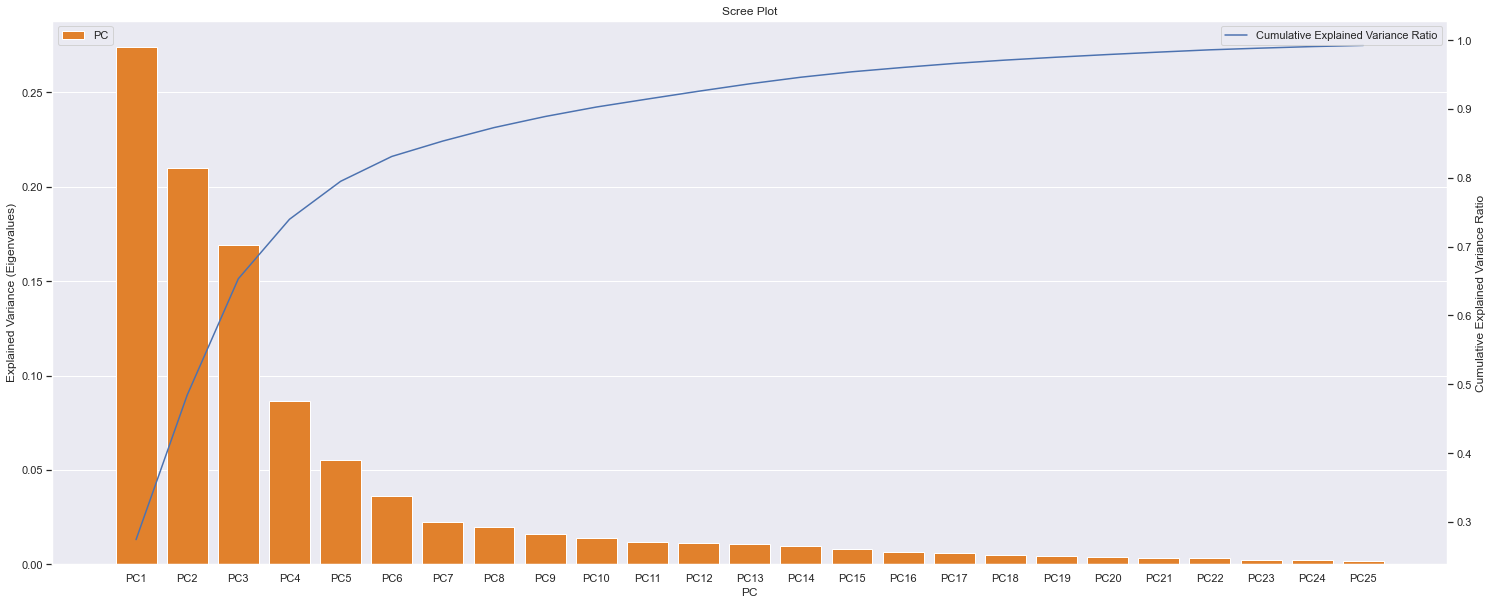

In [24]:
# Naming the PCs by iteration
pc_cols = [f'PC{n}' for n in range(1, n_components + 1)]
# Creating a pd.DataFrame containing the explained variance ratio from the PCA
pc_var_df = pd.DataFrame(
    {
        'Variance': pca.explained_variance_ratio_,
        'PC': pc_cols
    }
)

# Creating a subplot of the cumulative variance ratio & Eigenvalues
fig, ax1 = plt.subplots(figsize=(25, 10))
ax2 = ax1.twinx()

# Creating a barplot
sns.barplot(
    x='PC', y='Variance',
    data=pc_var_df,
    label='PC',
    color='tab:orange',
    ax=ax1
)

ax1.set_ylabel('Explained Variance (Eigenvalues)')
# Plotting the cumulative sum of Explained Variance Ratio
ax2.plot(
    np.cumsum(pca.explained_variance_ratio_),
    label='Cumulative Explained Variance Ratio'
)
plt.title('Scree Plot')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax1.legend(loc=2)
ax2.legend()
ax2.grid(b=None)
plt.show()

In [25]:
pc_var_df.head()

,Variance,PC
0,0.274310,PC1
1,0.210024,PC2
2,0.169032,PC3
3,0.086373,PC4
4,0.055172,PC5


##### Observations

As can be seen from the Scree plot and `pc_var_df.head()`, PCs 1 - 5 explain approximately 80% of the variance from LP1, with PC1 containing 27.4% of the variance from LP1. The amount of variance explained by each PC decreases exponentially until PC$n$, where $n =$ *Number of components*, at this point the explained variance will be 0.

---
## Random Forest Classification

This section constructs a Random Forest Classifier that is applied to all the datasets for both the binary-class and multi-class cases. The hyperparameters that were tuned are shown below. The importance of each parameter in determining the classification is also plotted.

This is the only model that uses the multi-class case.

In [26]:
# Setting hyperparameters
params = {
    # Number of trees in random forest
    'n_estimators': range(10, 400, 10),
    # Number of features to consider at every split, MAYBE ADD 'log2'
    'max_features': ['auto'],
    # Maximum number of levels in tree
    'max_depth': range(2, 25),
    # Minimum number of samples required to split a node
    'min_samples_split': range(2, 10),
    # Minimum number of samples required at each leaf node
    'min_samples_leaf': range(1, 10)
}

### 'Normal' or 'Failure' - Binary-Class

Dataset: LP1
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 370, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}



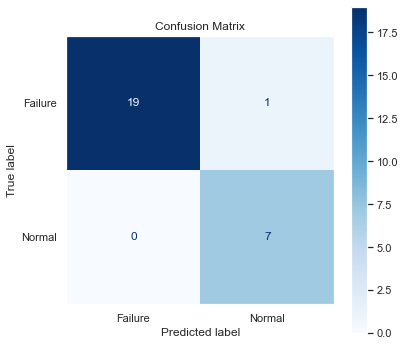

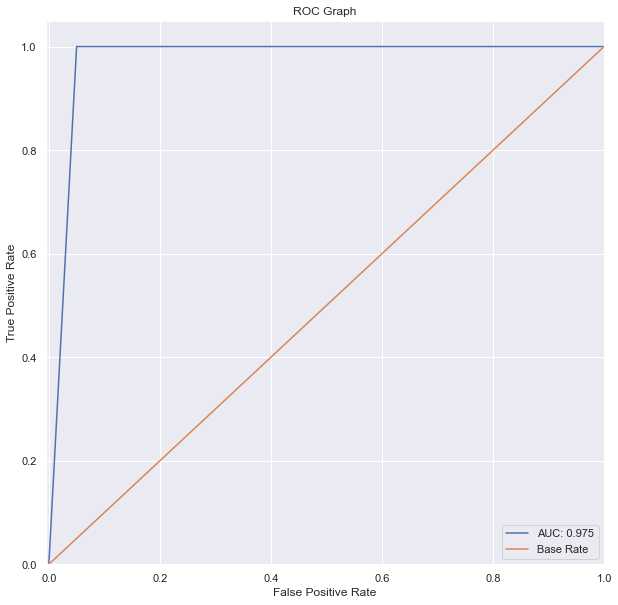

Time to fit best model: 0.5028355121612549 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.95      0.97        20
      Normal       0.88      1.00      0.93         7

    accuracy                           0.96        27
   macro avg       0.94      0.97      0.95        27
weighted avg       0.97      0.96      0.96        27

   accuracy  precision    recall    auc        F1  specificity
0  0.962963   0.967593  0.962963  0.975  0.963723         0.95



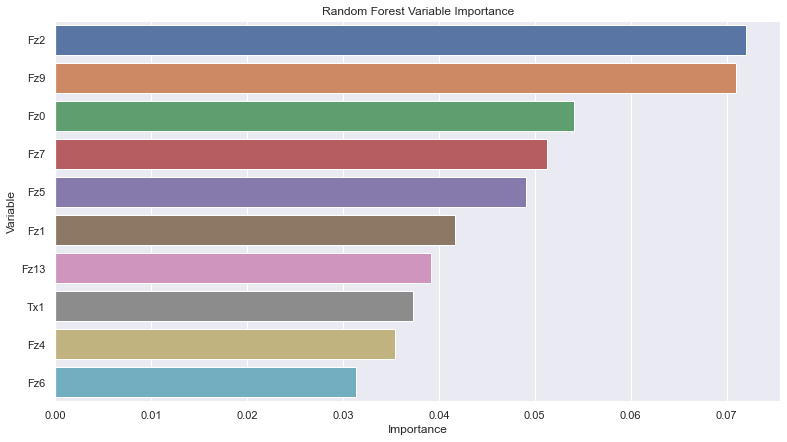

Dataset: LP2
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 370, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}



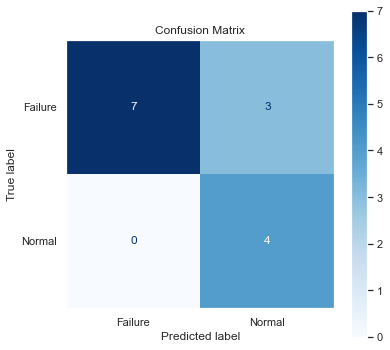

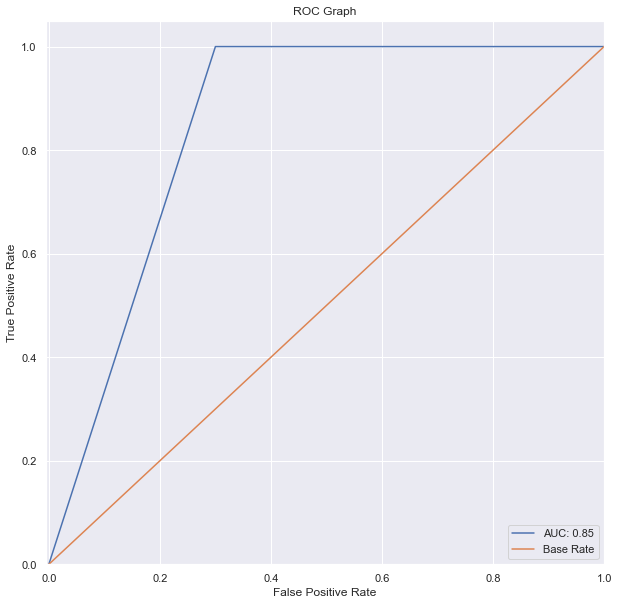

Time to fit best model: 0.5218279361724854 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.70      0.82        10
      Normal       0.57      1.00      0.73         4

    accuracy                           0.79        14
   macro avg       0.79      0.85      0.78        14
weighted avg       0.88      0.79      0.80        14

   accuracy  precision    recall   auc        F1  specificity
0  0.785714   0.877551  0.785714  0.85  0.796028          0.7



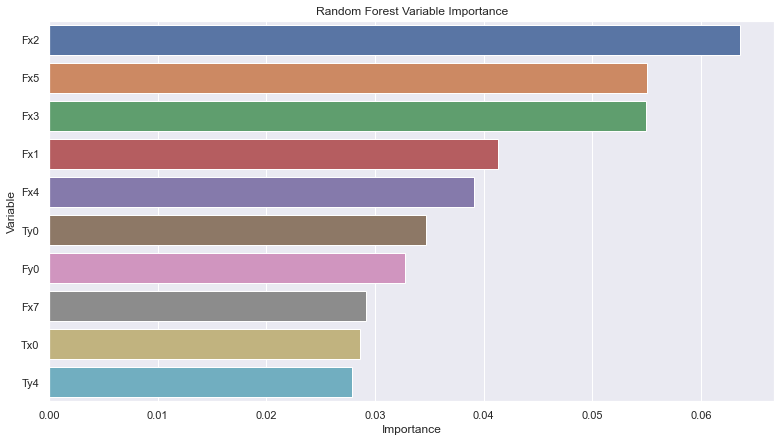

Dataset: LP3
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 370, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}



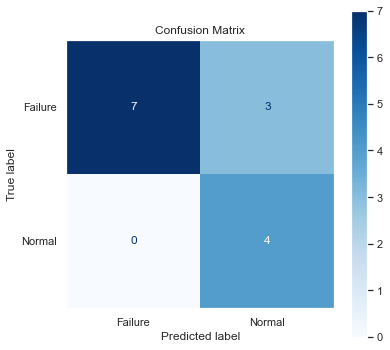

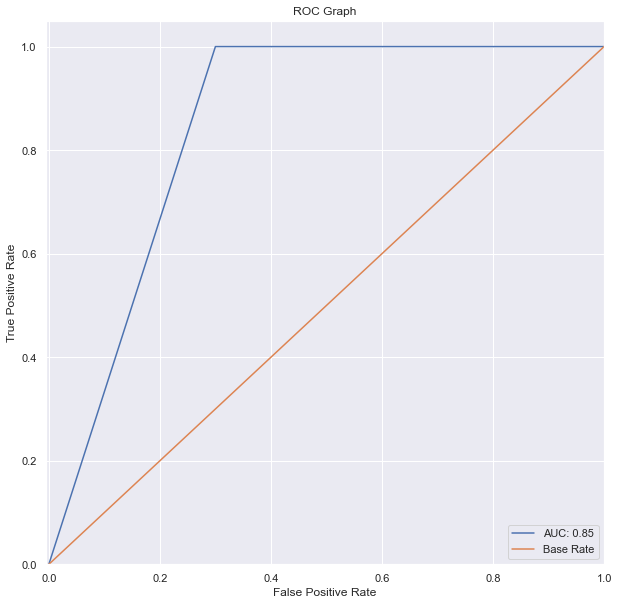

Time to fit best model: 0.5208287239074707 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.70      0.82        10
      Normal       0.57      1.00      0.73         4

    accuracy                           0.79        14
   macro avg       0.79      0.85      0.78        14
weighted avg       0.88      0.79      0.80        14

   accuracy  precision    recall   auc        F1  specificity
0  0.785714   0.877551  0.785714  0.85  0.796028          0.7



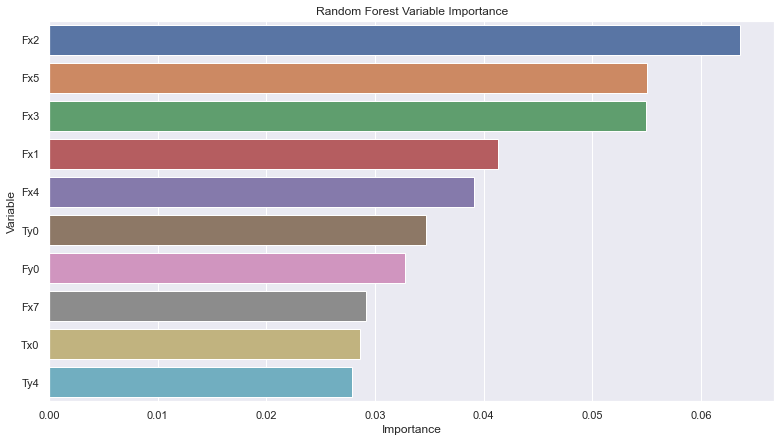

Dataset: LP4
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 370, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}



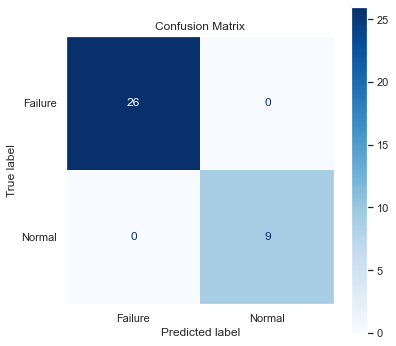

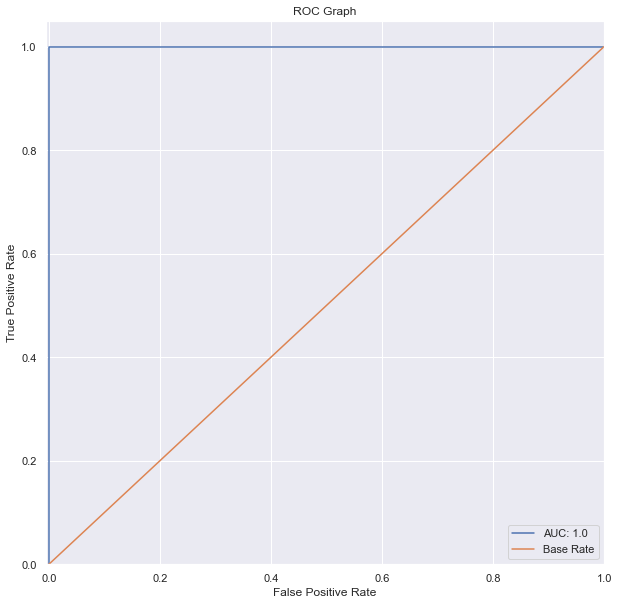

Time to fit best model: 0.5198290348052979 seconds
              precision    recall  f1-score   support

     Failure       1.00      1.00      1.00        26
      Normal       1.00      1.00      1.00         9

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35

   accuracy  precision  recall  auc   F1  specificity
0       1.0        1.0     1.0  1.0  1.0          1.0



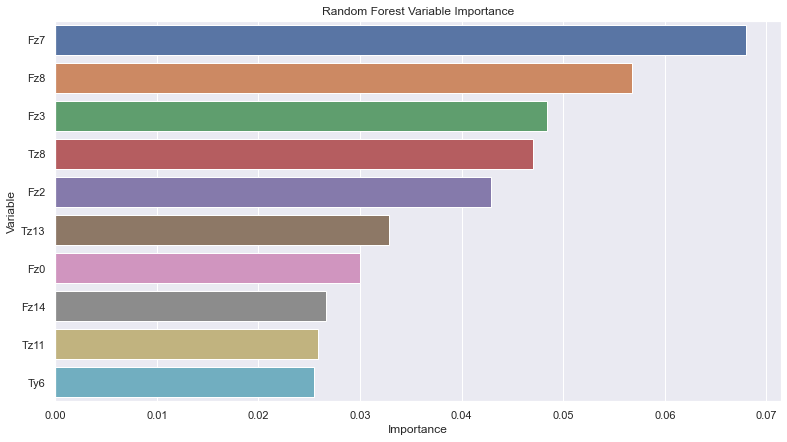

Dataset: LP5
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 70, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}



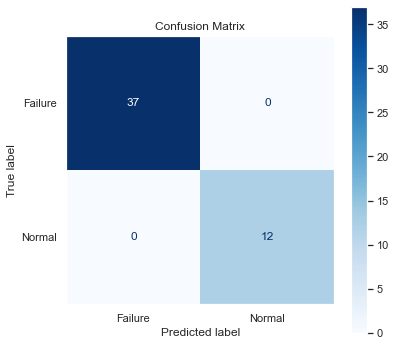

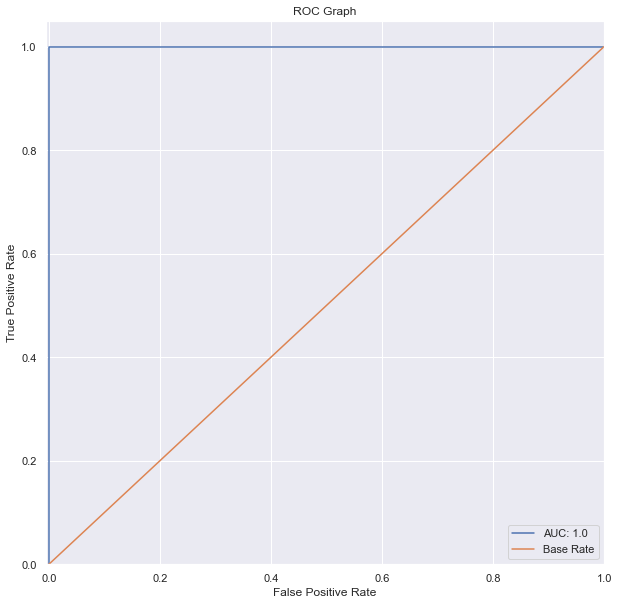

Time to fit best model: 0.11196231842041016 seconds
              precision    recall  f1-score   support

     Failure       1.00      1.00      1.00        37
      Normal       1.00      1.00      1.00        12

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49

   accuracy  precision  recall  auc   F1  specificity
0       1.0        1.0     1.0  1.0  1.0          1.0



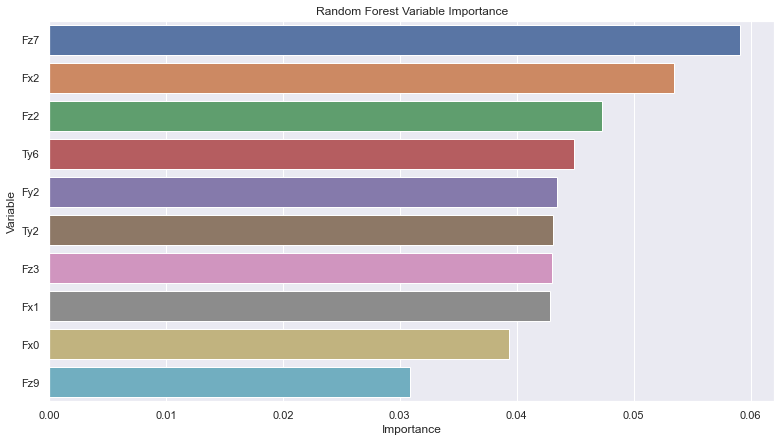

In [27]:
for dataset, input_cols, output_cols, name in binary_zipped_dict:
    print(f'Dataset: {name}')
    model = build_model(
        # The dataset to be used
        df=dataset,
        # The classifier to be used
        classifier=RandomForestClassifier(random_state=0),
        # The hyperparameters to be used
        hyperparams=params,
        # Amount of K Cross-folds to use, 
        # if cv=1 no folds are used
        cv=1,
        # Boolean, should SMOTE be used, default True
        smote=True,
        # Defining the size of the test dataset~
        test_size=0.3,
        # Number of iterations to determine best params
        n_iter=1000,
        # Input columns to be used
        input_cols=input_cols,
        # Output columns to be used
        output_cols=output_cols,
        # Boolean, should verbose be used, default True
        verbose=True
    )

    feature_importances = pd.DataFrame(model.feature_importances_,
        index=input_cols,
        columns=['importance']).sort_values('importance', ascending=False
    )
    feature_importances = feature_importances.reset_index()
    
    plt.figure(figsize=(13, 7))
    sns.barplot(
        x="importance", y='index',
        data=feature_importances[0:10], label="Total"
    )
    plt.title("Random Forest Variable Importance")
    plt.ylabel("Variable")
    plt.xlabel("Importance")
    plt.show()
    
    print('=' * 125)

### All Failure Modes - Multi-Class

Dataset: LP1
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 370, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}



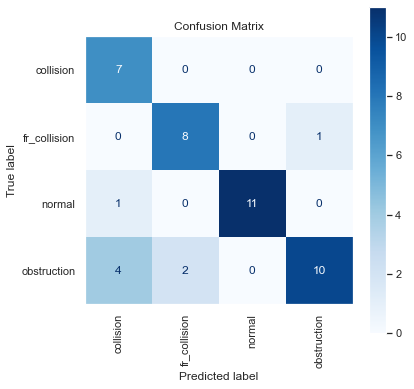

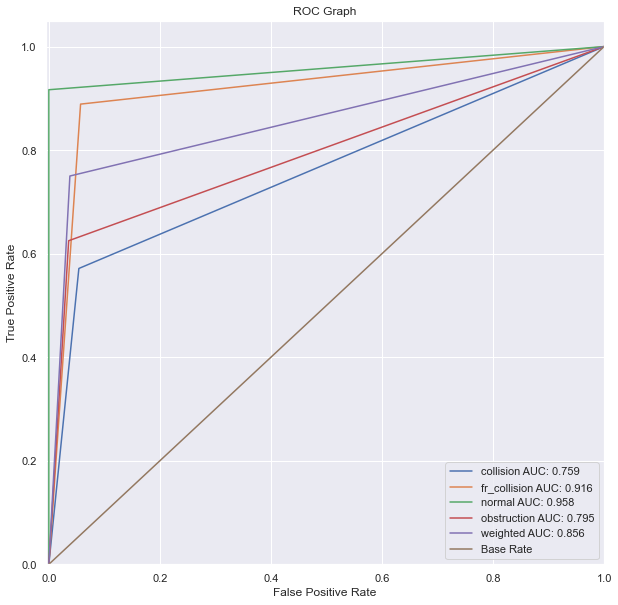

Time to fit best model: 0.5708131790161133 seconds
              precision    recall  f1-score   support

   collision       0.67      0.57      0.62         7
fr_collision       0.80      0.89      0.84         9
      normal       1.00      0.92      0.96        12
 obstruction       0.91      0.62      0.74        16

   micro avg       0.87      0.75      0.80        44
   macro avg       0.84      0.75      0.79        44
weighted avg       0.87      0.75      0.80        44
 samples avg       0.75      0.75      0.75        44

   accuracy  precision  recall       auc        F1
0  0.818182   0.873003    0.75  0.858363  0.800381

Dataset: LP2
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_sam

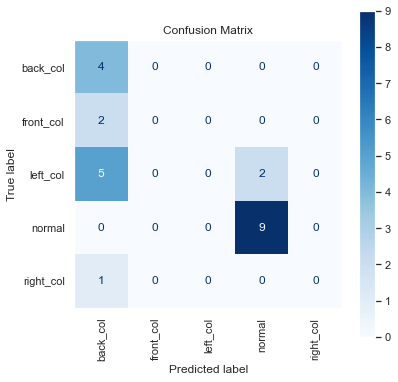

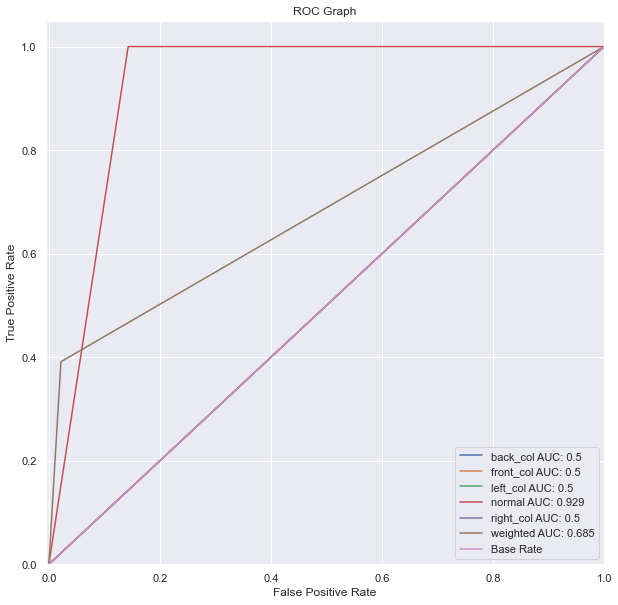

Time to fit best model: 0.5808091163635254 seconds
              precision    recall  f1-score   support

    back_col       0.00      0.00      0.00         4
   front_col       0.00      0.00      0.00         2
    left_col       0.00      0.00      0.00         7
      normal       0.82      1.00      0.90         9
   right_col       0.00      0.00      0.00         1

   micro avg       0.82      0.39      0.53        23
   macro avg       0.16      0.20      0.18        23
weighted avg       0.32      0.39      0.35        23
 samples avg       0.39      0.39      0.39        23

   accuracy  precision    recall       auc        F1
0  0.565217   0.320158  0.391304  0.667702  0.352174

Dataset: LP3
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, '

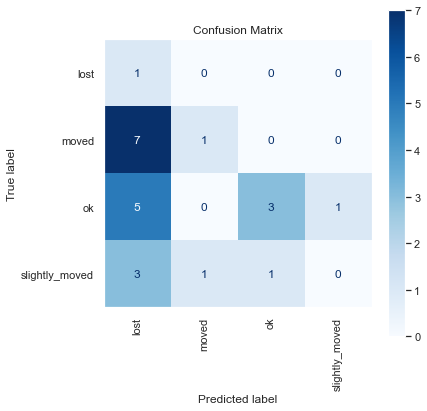

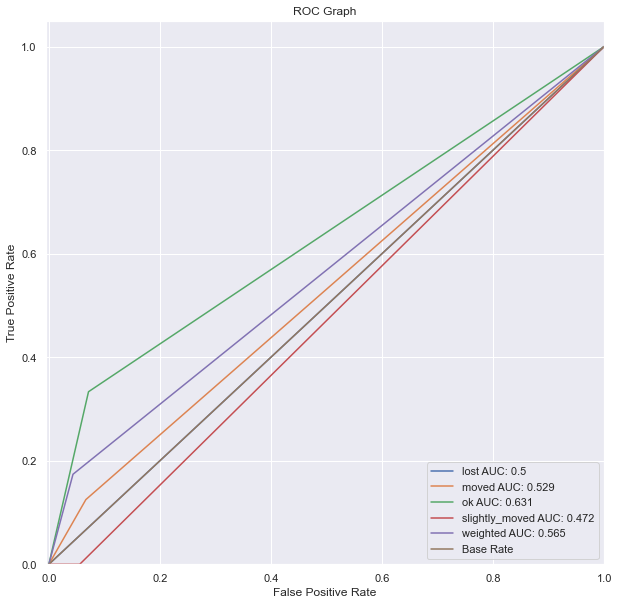

Time to fit best model: 0.03398847579956055 seconds
                precision    recall  f1-score   support

          lost       0.00      0.00      0.00         1
         moved       0.50      0.12      0.20         8
            ok       0.75      0.33      0.46         9
slightly_moved       0.00      0.00      0.00         5

     micro avg       0.57      0.17      0.27        23
     macro avg       0.31      0.11      0.17        23
  weighted avg       0.47      0.17      0.25        23
   samples avg       0.17      0.17      0.17        23

   accuracy  precision    recall       auc        F1
0  0.217391   0.467391  0.173913  0.555349  0.250167

Dataset: LP4
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_sam

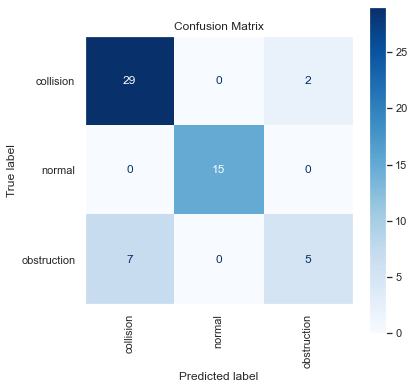

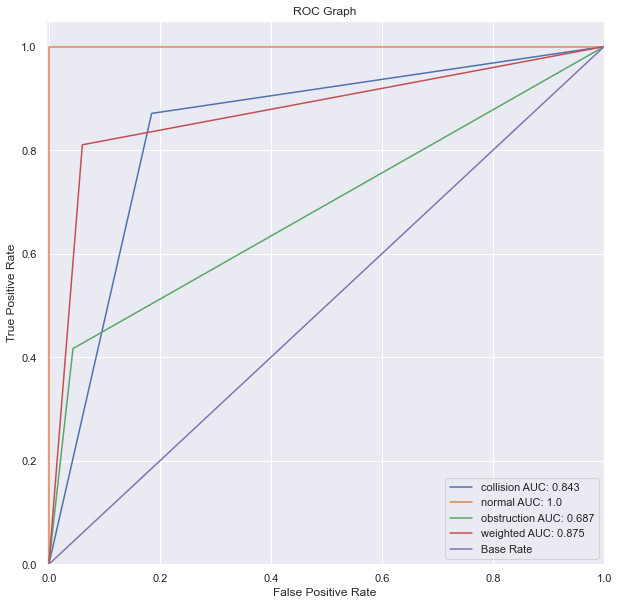

Time to fit best model: 0.5968034267425537 seconds
              precision    recall  f1-score   support

   collision       0.84      0.87      0.86        31
      normal       1.00      1.00      1.00        15
 obstruction       0.71      0.42      0.53        12

   micro avg       0.87      0.81      0.84        58
   macro avg       0.85      0.76      0.79        58
weighted avg       0.86      0.81      0.83        58
 samples avg       0.81      0.81      0.81        58

   accuracy  precision    recall       auc        F1
0  0.844828   0.857374  0.810345  0.851186  0.825642

Dataset: LP5
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, '

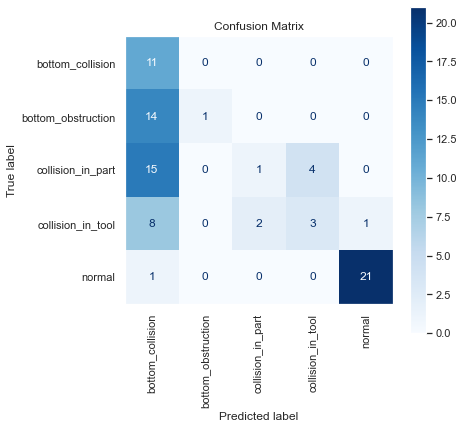

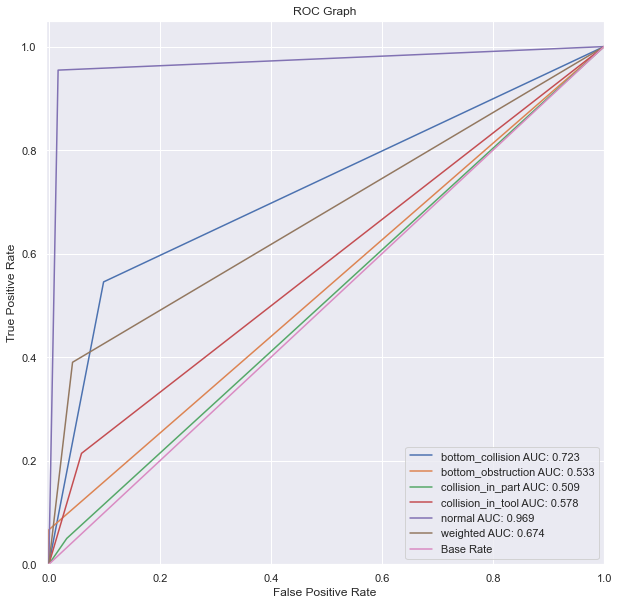

Time to fit best model: 0.08497214317321777 seconds
                    precision    recall  f1-score   support

  bottom_collision       0.46      0.55      0.50        11
bottom_obstruction       1.00      0.07      0.12        15
 collision_in_part       0.33      0.05      0.09        20
 collision_in_tool       0.43      0.21      0.29        14
            normal       0.95      0.95      0.95        22

         micro avg       0.70      0.39      0.50        82
         macro avg       0.64      0.37      0.39        82
      weighted avg       0.66      0.39      0.42        82
       samples avg       0.39      0.39      0.39        82

   accuracy  precision    recall       auc        F1
0   0.45122    0.65541  0.390244  0.677318  0.416026



In [28]:
for dataset, input_cols, output_cols, name in multi_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        df=dataset,
        classifier=RandomForestClassifier(random_state=0),
        hyperparams=params,
        cv=1,
        smote=True,
        test_size=0.5,
        n_iter=1000,
        input_cols=input_cols,
        output_cols=output_cols,
        verbose=True
    )
    print('=' * 125)

### Discussion

This section will give a brief discussion of the results from the Random Forest Classifier shown above, more in-depth analysis will be done in the report.

#### Binary-Class

The results for the binary-class case can clearly be shown to be better than for the multi-class case, as would be expected. Simplifying the problem from multiple classification types to *'Normal'* or *'Failure'* has clear advantages when producing a model with explainable metrics. Since the datasets are so small and contain large class imbalances, converting the classifications solves some of the issues that are present in the datasets.\
Applying **SMOTE** alleviates the class imbalances in the training dataset. However, as previously mentioned, **SMOTE** isn't applied to the test dataset so the class imbalance issues can't be solved for the test dataset.

#### Multi-Class

As can be seen from the multi-class results, some of the metrics are simply unable to be calculated (for example, precision and F1-score for some classifications in LP2-3); this is shown from the repeated `UndefinedMetricWarning: Precision and F-score are ill-defined`. As the model never predicted certain classifications in the test set, the precision and F1-score metrics cannot be calculated as it would always result in a value of 0. As can be seen, some classifications (namely the *'lost'* classification in LP3) only contain 1 example in the test dataset, even with a test/train split of 50/50, which is not enough to determine any insightful information from the model.

### Conclusions

As a result of the issues present within the datasets and the inability of the multi-class models to produce some metrics, only the binary-class classification will be used for the rest of the models. Although this the specific failure type will not be able to be determined, determining if the robot is operating normally or has failed accurately is more important than determining the specific failure type that has occurred.

---
## XGBoost

In [29]:
# Setting hyperparameters
params = {
    # Maximum depth of a given tree
    'max_depth': range(2, 10),
    # Amount to shrink feature weights for boosting process
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    # Subsample ratio of the training instances
    'subsample': [0.8, 0.85, 0.9, 1.0],
    # Subsample ratio of columns when constructing trees
    'colsample_bytree': np.arange(0.3, 1, 0.1),
    # Minimum loss reduction to make additional partition on leaf node
    'gamma': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
    # L2 regularization term on weights
    'reg_lambda': [1, 1.5, 2, 3, 4.5],
    # Number of estimators in the decision tree
    'n_estimators': range(50, 400, 10)
}

Dataset: LP1
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.4, 'gamma': 2, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 300, 'n_jobs': 4, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 2, 'scale_pos_weight': 1, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': 0, 'silent': 1, 'eval_metric': 'logloss'}



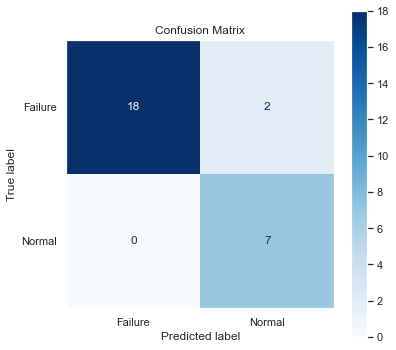

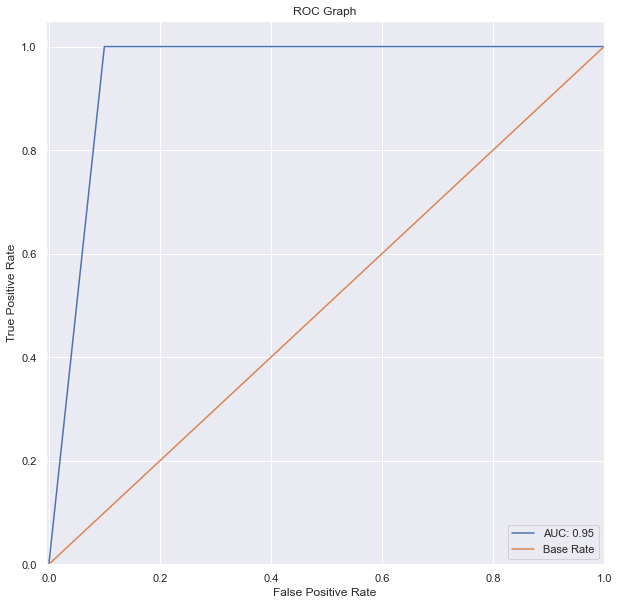

Time to fit best model: 0.22292661666870117 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.90      0.95        20
      Normal       0.78      1.00      0.88         7

    accuracy                           0.93        27
   macro avg       0.89      0.95      0.91        27
weighted avg       0.94      0.93      0.93        27

   accuracy  precision    recall   auc        F1  specificity
0  0.925926   0.942387  0.925926  0.95  0.928606          0.9

Dataset: LP2
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.4, 'gamma': 2, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estima

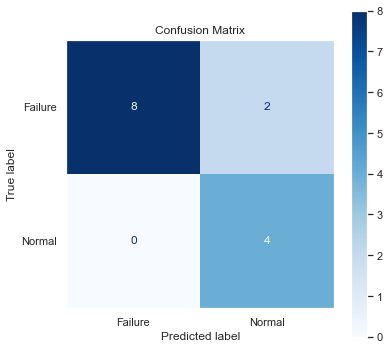

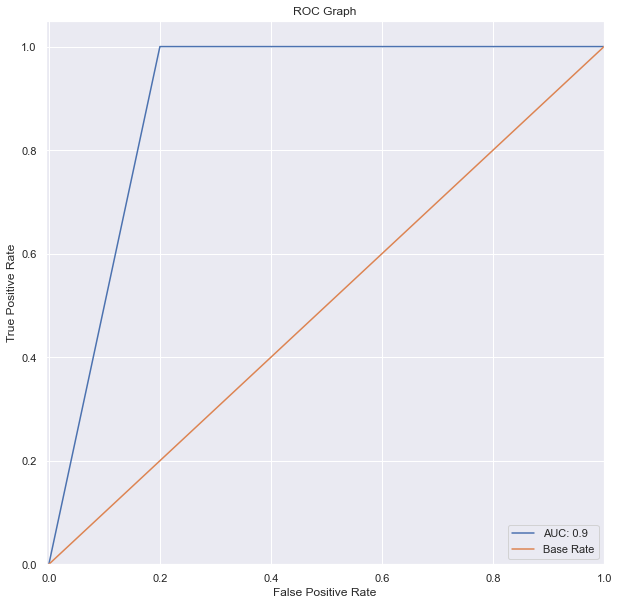

Time to fit best model: 0.09896731376647949 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.80      0.89        10
      Normal       0.67      1.00      0.80         4

    accuracy                           0.86        14
   macro avg       0.83      0.90      0.84        14
weighted avg       0.90      0.86      0.86        14

   accuracy  precision    recall  auc        F1  specificity
0  0.857143   0.904762  0.857143  0.9  0.863492          0.8

Dataset: LP3
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.4, 'gamma': 2, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimato

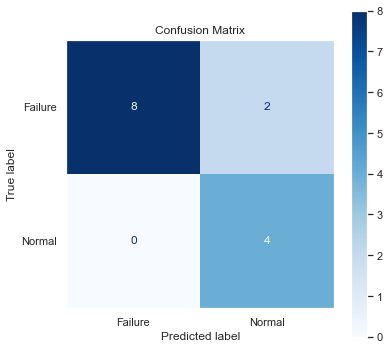

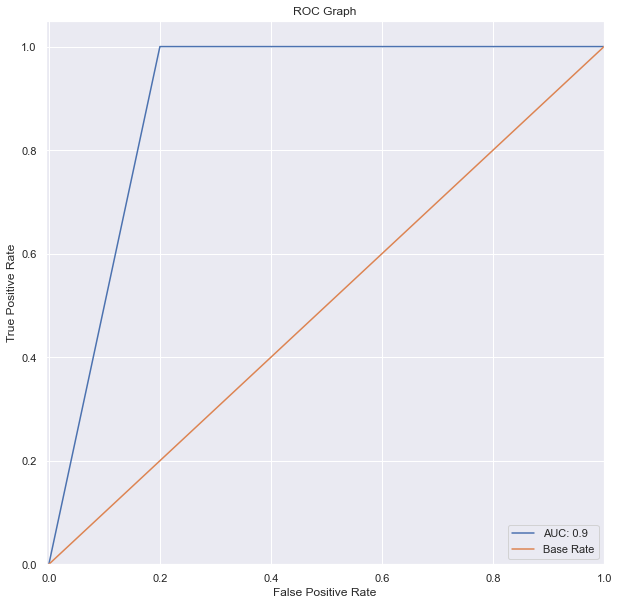

Time to fit best model: 0.10296630859375 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.80      0.89        10
      Normal       0.67      1.00      0.80         4

    accuracy                           0.86        14
   macro avg       0.83      0.90      0.84        14
weighted avg       0.90      0.86      0.86        14

   accuracy  precision    recall  auc        F1  specificity
0  0.857143   0.904762  0.857143  0.9  0.863492          0.8

Dataset: LP4
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.4, 'gamma': 2, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators'

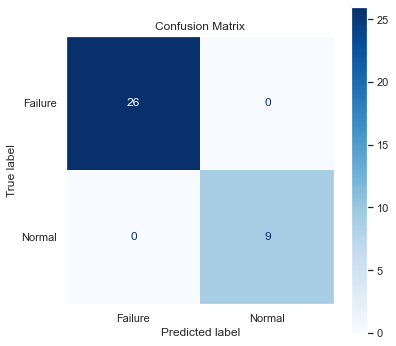

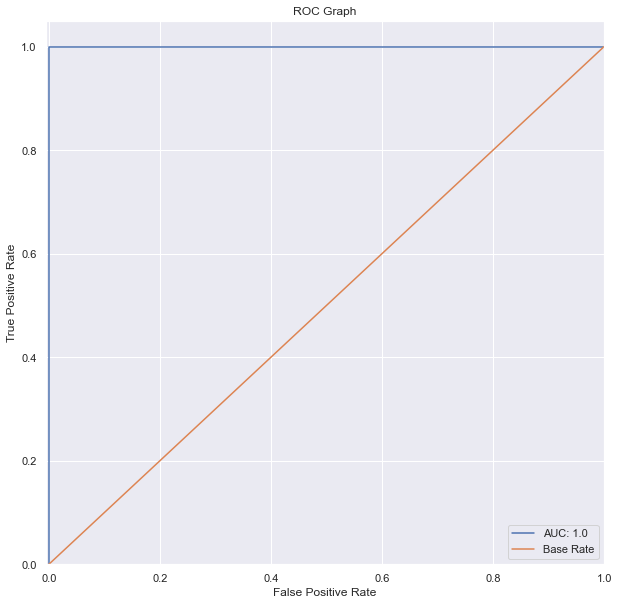

Time to fit best model: 0.14095354080200195 seconds
              precision    recall  f1-score   support

     Failure       1.00      1.00      1.00        26
      Normal       1.00      1.00      1.00         9

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35

   accuracy  precision  recall  auc   F1  specificity
0       1.0        1.0     1.0  1.0  1.0          1.0

Dataset: LP5
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7000000000000002, 'gamma': 0.3, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.0001, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_est

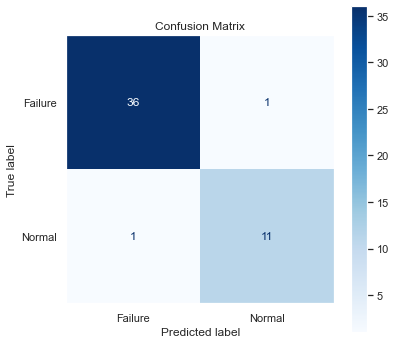

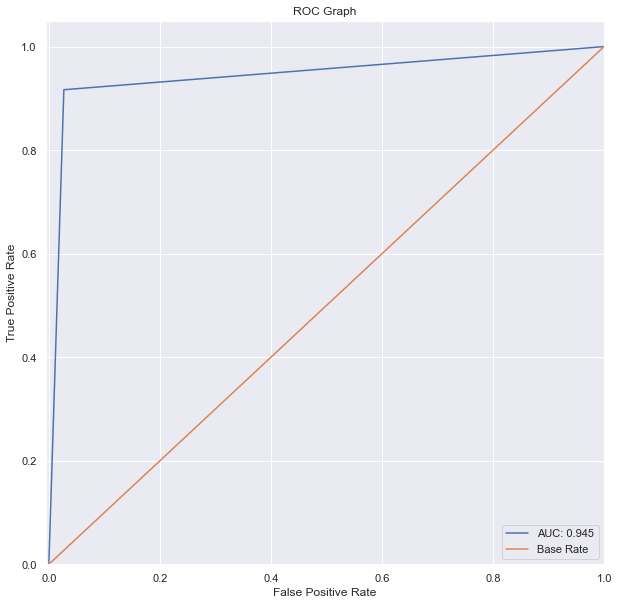

Time to fit best model: 0.16194725036621094 seconds
              precision    recall  f1-score   support

     Failure       0.97      0.97      0.97        37
      Normal       0.92      0.92      0.92        12

    accuracy                           0.96        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.96      0.96      0.96        49

   accuracy  precision    recall      auc        F1  specificity
0  0.959184   0.959184  0.959184  0.94482  0.959184     0.972973



In [30]:
for dataset, input_cols, output_cols, name in binary_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        # The dataset to be used
        df=dataset,
        # The classifier to be used
        classifier=xgb.XGBClassifier(
            use_label_encoder=False, silent=1,
            eval_metric='logloss', verbosity=0
        ),
        # The hyperparameters to be used
        hyperparams=params,
        # Amount of K Cross-folds to use, 
        # if cv=1 no folds are used
        cv=1,
        # Boolean, should SMOTE be used, default True
        smote=True,
        # Defining the size of the test dataset
        test_size=0.3,
        # Number of iterations to determine best params
        n_iter=1000,
        # Input columns to be used
        input_cols=input_cols,
        # Output columns to be used
        output_cols=output_cols,
        # Boolean, should verbose be used, default True
        verbose=True
    )
    print('=' * 125)

## Discussion

XGBoost appears to provide better results than the Random Forest Classifier, improving the accuracy for LP2-3 by approximately 7.2%. It also improves the precision and F1-score for LP2-3. The only datasets that showed a decline in results were LP1 & LP5, although only by approximately 4% accuracy. As a result, the XGBoost model is assumed to be an improved decicision tree machine-learning technique for this dataset than Random Forest.

Again, these results will be discussed in more detail in the **report**.

---
## K-Nearest Neighbours

In [31]:
# Setting hyperparameters
params = {
    # Number of neighbors for clustering
    'n_neighbors': range(1, 30),
    # Leaf size passed to the chosen algorithm
    'leaf_size': range(1, 50),
    # Power parameter, 1 for Minkowski, 2 for Euclidean
    'p': [1, 2]
}

Dataset: LP1
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}



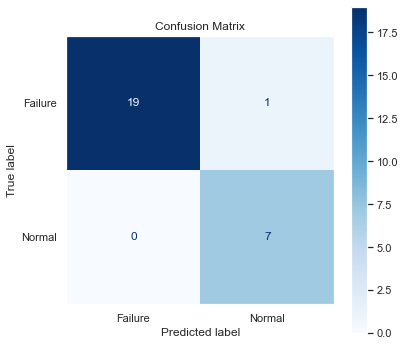

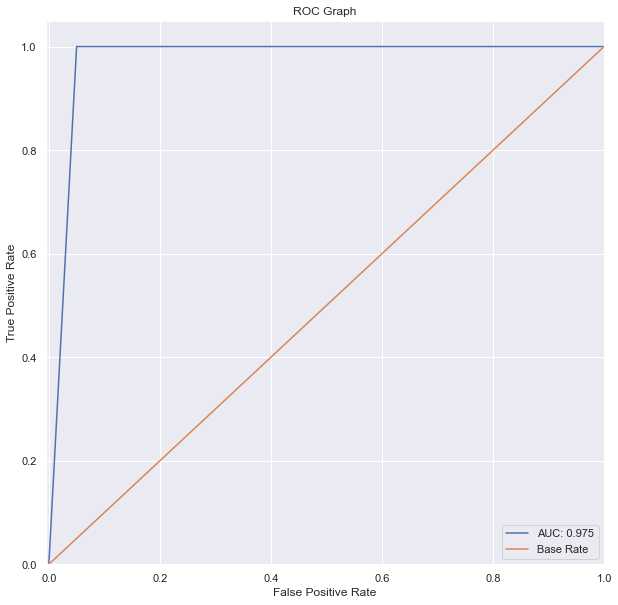

Time to fit best model: 0.002999544143676758 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.95      0.97        20
      Normal       0.88      1.00      0.93         7

    accuracy                           0.96        27
   macro avg       0.94      0.97      0.95        27
weighted avg       0.97      0.96      0.96        27

   accuracy  precision    recall    auc        F1  specificity
0  0.962963   0.967593  0.962963  0.975  0.963723         0.95

Dataset: LP2
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}



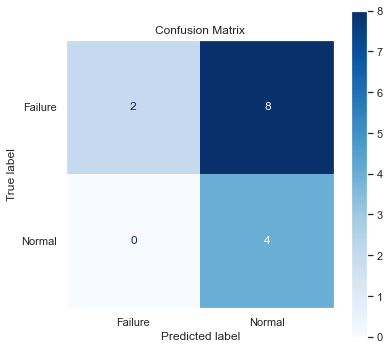

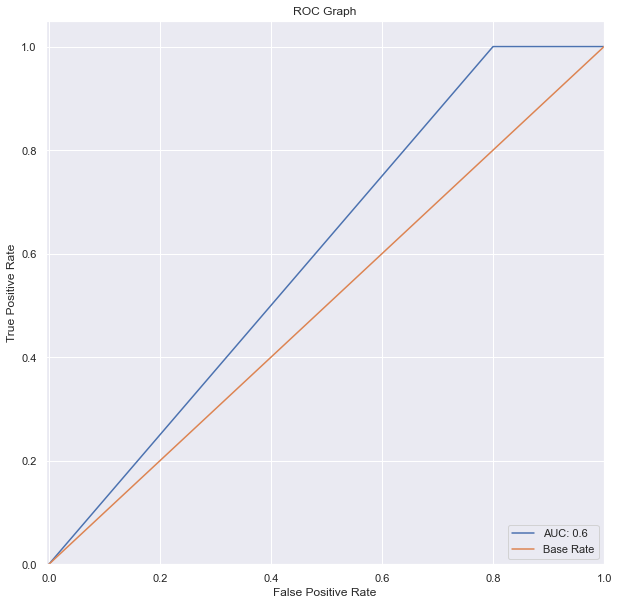

Time to fit best model: 0.001999378204345703 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.20      0.33        10
      Normal       0.33      1.00      0.50         4

    accuracy                           0.43        14
   macro avg       0.67      0.60      0.42        14
weighted avg       0.81      0.43      0.38        14

   accuracy  precision    recall  auc        F1  specificity
0  0.428571   0.809524  0.428571  0.6  0.380952          0.2

Dataset: LP3
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'algorithm': 'auto', 'leaf_size': 3, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}



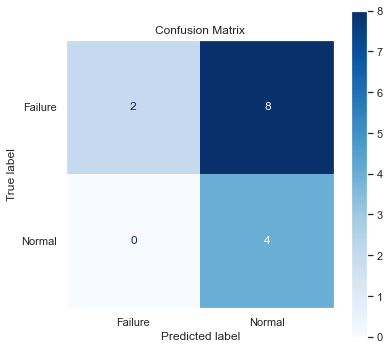

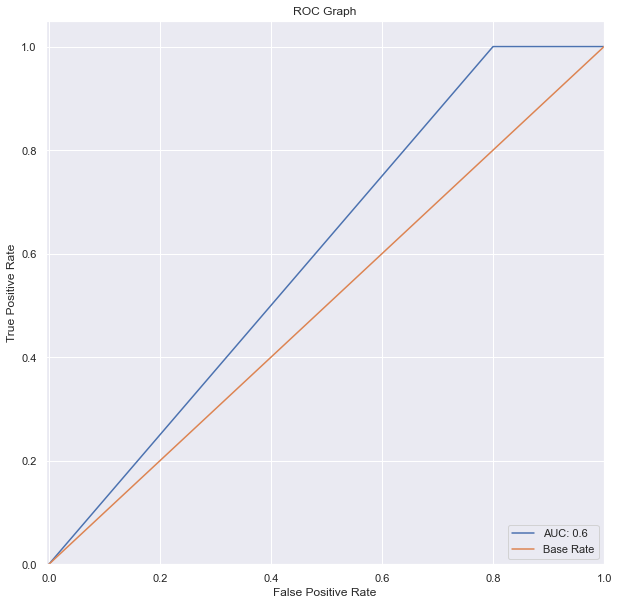

Time to fit best model: 0.001999378204345703 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.20      0.33        10
      Normal       0.33      1.00      0.50         4

    accuracy                           0.43        14
   macro avg       0.67      0.60      0.42        14
weighted avg       0.81      0.43      0.38        14

   accuracy  precision    recall  auc        F1  specificity
0  0.428571   0.809524  0.428571  0.6  0.380952          0.2

Dataset: LP4
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'algorithm': 'auto', 'leaf_size': 37, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}



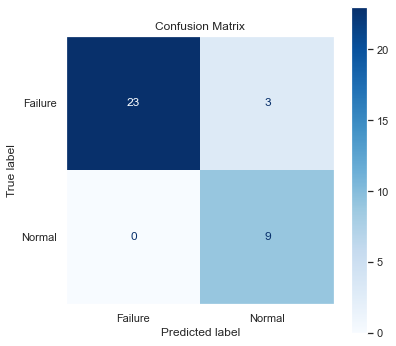

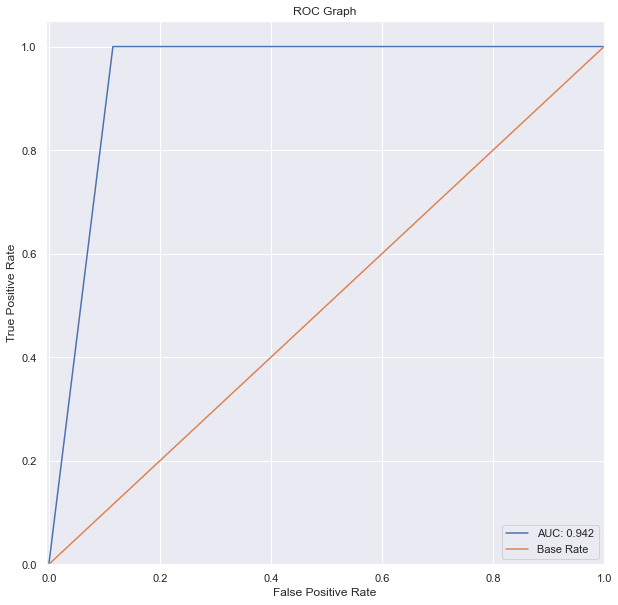

Time to fit best model: 0.001999378204345703 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.88      0.94        26
      Normal       0.75      1.00      0.86         9

    accuracy                           0.91        35
   macro avg       0.88      0.94      0.90        35
weighted avg       0.94      0.91      0.92        35

   accuracy  precision    recall       auc        F1  specificity
0  0.914286   0.935714  0.914286  0.942308  0.917784     0.884615

Dataset: LP5
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'algorithm': 'auto', 'leaf_size': 29, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}



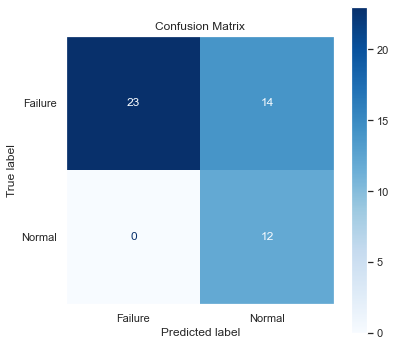

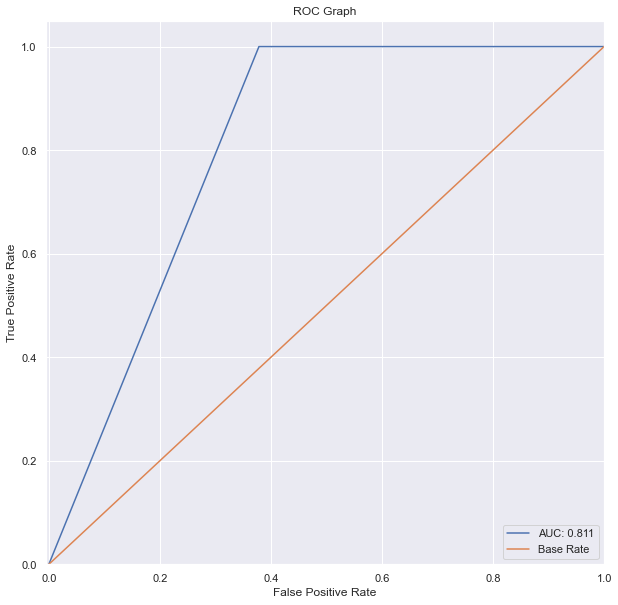

Time to fit best model: 0.0029990673065185547 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.62      0.77        37
      Normal       0.46      1.00      0.63        12

    accuracy                           0.71        49
   macro avg       0.73      0.81      0.70        49
weighted avg       0.87      0.71      0.73        49

   accuracy  precision    recall       auc        F1  specificity
0  0.714286   0.868132  0.714286  0.810811  0.733584     0.621622



In [32]:
for dataset, input_cols, output_cols, name in binary_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        # The dataset to be used
        df=dataset,
        # The classifier to be used
        classifier=KNeighborsClassifier(),
        # The hyperparameters to be used
        hyperparams=params,
        # Amount of K Cross-folds to use, 
        # if cv=1 no folds are used
        cv=1,
        # Boolean, should SMOTE be used, default True
        smote=True,
        # Defining the size of the test dataset
        test_size=0.3,
        # Number of iterations to determine best params
        n_iter=1000,
        # Input columns to be used
        input_cols=input_cols,
        # Output columns to be used
        output_cols=output_cols,
        # Boolean, should verbose be used, default True
        verbose=True
    )
    print('=' * 125)

### Discussion

As can be seen, K-nearest neighbors produces vastly inferior results for LP2, LP3 and LP5 when compared to both the decision tree methods. LP1 and LP4 have comparable accuracy metrics to the decision tree models. One advantage to the K-nearest neighbors algorithm is the much faster time to fit the model. However this is a difference of less than a second; the increased accuracy of the other models is definitely preferable in this instance. If the dataset was larger, K-nearest neighbors may perform better and the faster time to fit would become a more important factor.

K-nearest neighbors is known not to perform very well on high-dimensional data which may be why it produces worse results.

---
## Naive Bayes

In [33]:
# Setting hyperparameters
params = {
    # Portion of largest variance across all features added to variances
    'var_smoothing': np.logspace(0,-9, 100),
}

Dataset: LP1
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best Hyperparameters: 
{'priors': None, 'var_smoothing': 0.0003511191734215131}



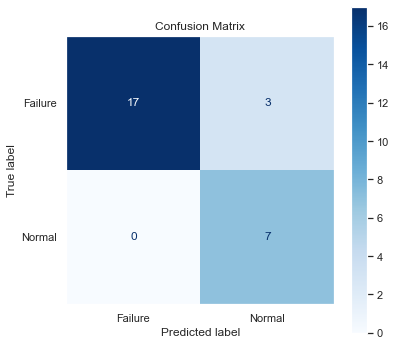

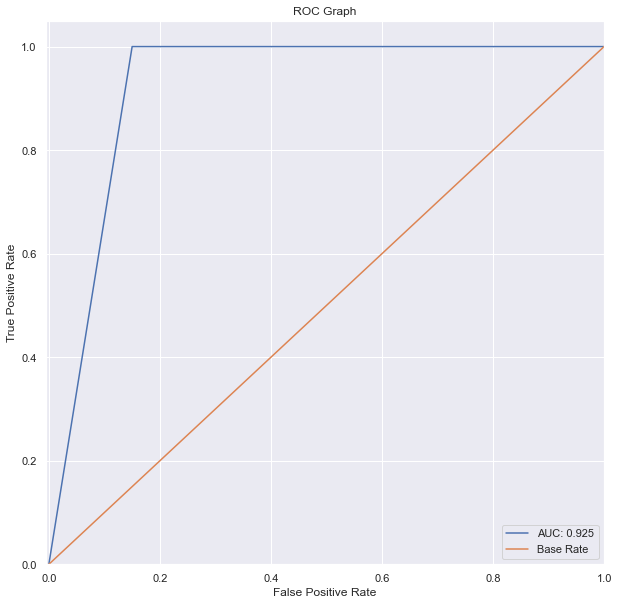

Time to fit best model: 0.0019991397857666016 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.85      0.92        20
      Normal       0.70      1.00      0.82         7

    accuracy                           0.89        27
   macro avg       0.85      0.93      0.87        27
weighted avg       0.92      0.89      0.89        27

   accuracy  precision    recall    auc        F1  specificity
0  0.888889   0.922222  0.888889  0.925  0.894188         0.85

Dataset: LP2
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best Hyperparameters: 
{'priors': None, 'var_smoothing': 0.3511191734215131}



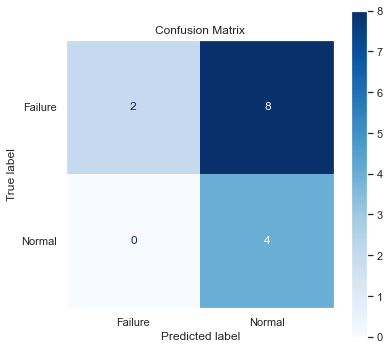

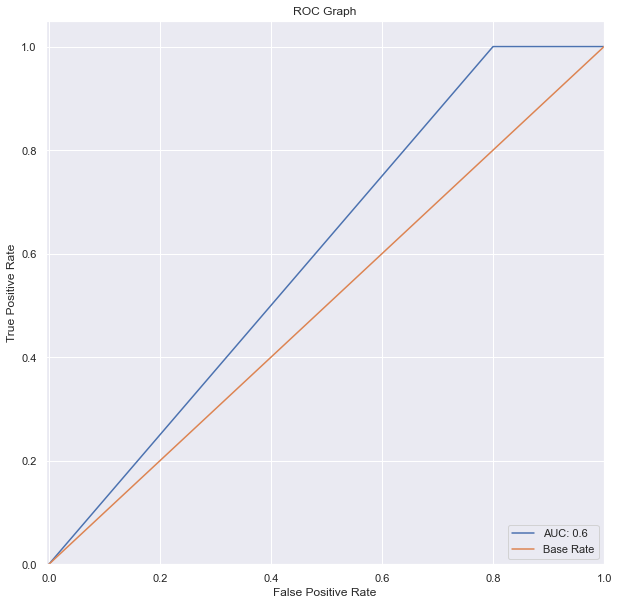

Time to fit best model: 0.0029993057250976562 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.20      0.33        10
      Normal       0.33      1.00      0.50         4

    accuracy                           0.43        14
   macro avg       0.67      0.60      0.42        14
weighted avg       0.81      0.43      0.38        14

   accuracy  precision    recall  auc        F1  specificity
0  0.428571   0.809524  0.428571  0.6  0.380952          0.2

Dataset: LP3
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best Hyperparameters: 
{'priors': None, 'var_smoothing': 0.3511191734215131}



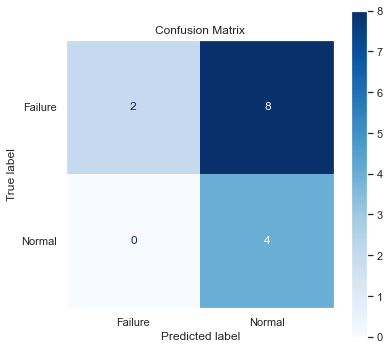

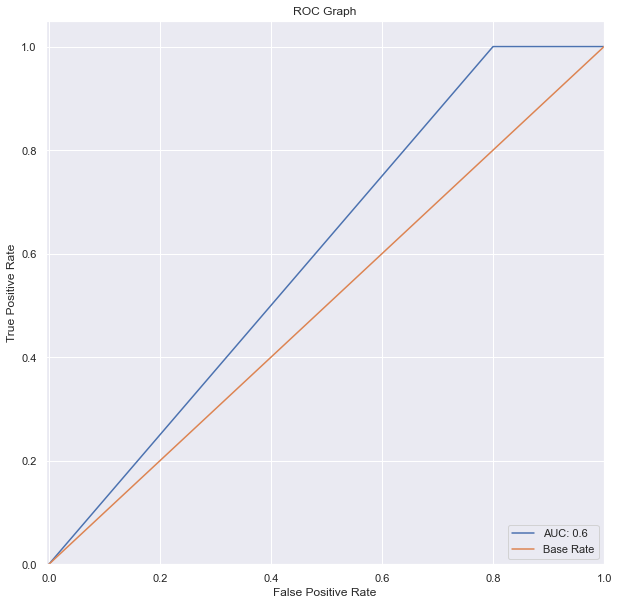

Time to fit best model: 0.003998279571533203 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.20      0.33        10
      Normal       0.33      1.00      0.50         4

    accuracy                           0.43        14
   macro avg       0.67      0.60      0.42        14
weighted avg       0.81      0.43      0.38        14

   accuracy  precision    recall  auc        F1  specificity
0  0.428571   0.809524  0.428571  0.6  0.380952          0.2

Dataset: LP4
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best Hyperparameters: 
{'priors': None, 'var_smoothing': 2.310129700083158e-05}



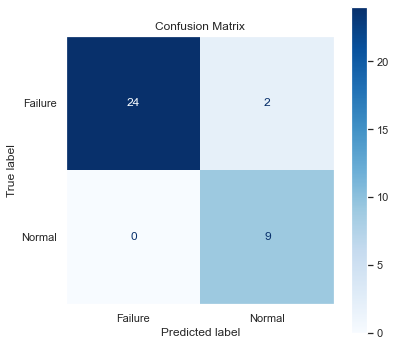

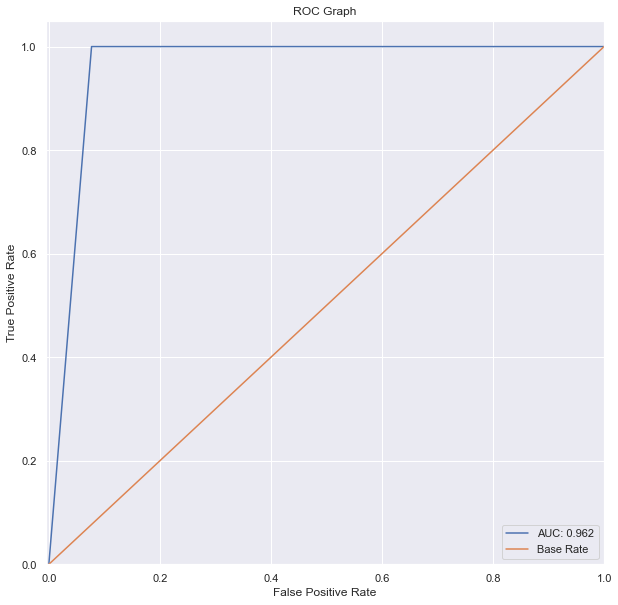

Time to fit best model: 0.0029985904693603516 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.92      0.96        26
      Normal       0.82      1.00      0.90         9

    accuracy                           0.94        35
   macro avg       0.91      0.96      0.93        35
weighted avg       0.95      0.94      0.94        35

   accuracy  precision    recall       auc        F1  specificity
0  0.942857   0.953247  0.942857  0.961538  0.944571     0.923077

Dataset: LP5
Fitting 1 folds for each of 100 candidates, totalling 100 fits
Best Hyperparameters: 
{'priors': None, 'var_smoothing': 3.5111917342151275e-06}



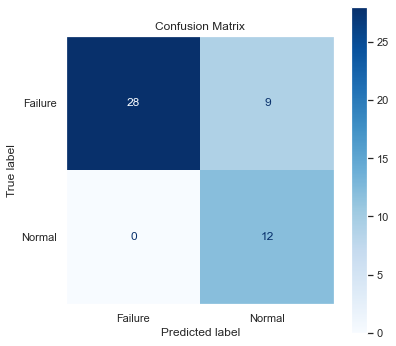

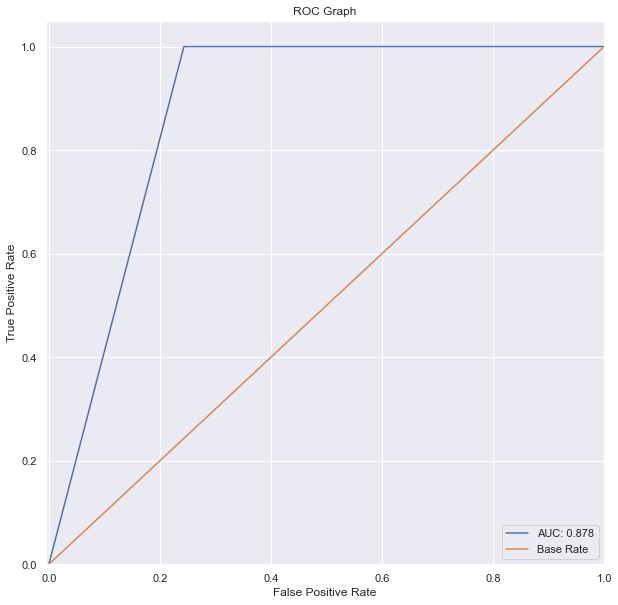

Time to fit best model: 0.002999544143676758 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.76      0.86        37
      Normal       0.57      1.00      0.73        12

    accuracy                           0.82        49
   macro avg       0.79      0.88      0.79        49
weighted avg       0.90      0.82      0.83        49

   accuracy  precision    recall       auc        F1  specificity
0  0.816327   0.895044  0.816327  0.878378  0.828657     0.756757



In [34]:
for dataset, input_cols, output_cols, name in binary_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        # The dataset to be used
        df=dataset,
        # The classifier to be used
        classifier=GaussianNB(),
        # The hyperparameters to be used
        hyperparams=params,
        # Amount of K Cross-folds to use, 
        # if cv=1 no folds are used
        cv=1,
        # Boolean, should SMOTE be used, default True
        smote=True,
        # Defining the size of the test dataset
        test_size=0.3,
        # Number of iterations to determine best params
        n_iter=1000,
        # Input columns to be used
        input_cols=input_cols,
        # Output columns to be used
        output_cols=output_cols,
        # Boolean, should verbose be used, default True
        verbose=True
    )
    print('=' * 125)

### Discussion

Gaussian Naive Bayes produces good results for LP1, LP4, and LP5; although not as good as the deicision tree models. The accuracy for LP2-3 is the same as with the K-nearest neighbors model, both performing extremely poorly on the smaller datasets.\
Naive Bayes does have an advantage in the time taken to train the model. However, as with the K-nearest model, it is not enough of a difference to make up for the significantly worse accuracy.

Naive Bayes does have an advantage with these types of datasets though. Since it treats all features as being independent, it solves some of the problems that arise from the **curse of dimensionality** in these high-dimensional datasets. For example, if there is data with $k$ dimensions, a general ML model would attempt to learn all correlation between all features, meaning $2^k$ possible interactions. Since Naive Bayes assumes independence between all features, it generally only requires $k$ data points to be effective. As can be seen from the above model, despite this Naive Bayes does not perform well.

---
## SVM - Linear Kernel

In [35]:
# Setting hyperparameters
params = {
    # Regularization parameter
    'C': np.arange(0.1, 100, 0.1)
}

Dataset: LP1
Fitting 1 folds for each of 999 candidates, totalling 999 fits
Best Hyperparameters: 
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



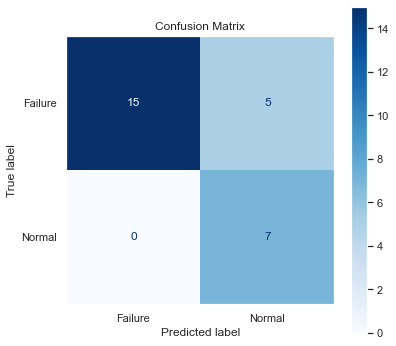

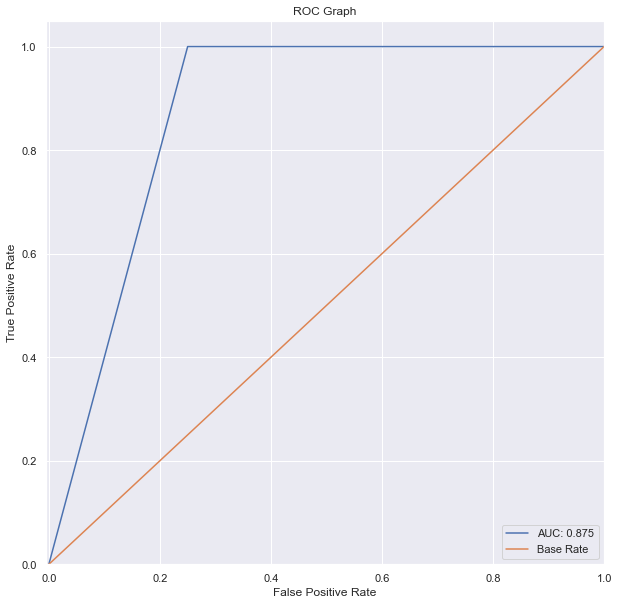

Time to fit best model: 0.004997730255126953 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.75      0.86        20
      Normal       0.58      1.00      0.74         7

    accuracy                           0.81        27
   macro avg       0.79      0.88      0.80        27
weighted avg       0.89      0.81      0.83        27

   accuracy  precision    recall    auc        F1  specificity
0  0.814815   0.891975  0.814815  0.875  0.825954         0.75

Dataset: LP2
Fitting 1 folds for each of 999 candidates, totalling 999 fits
Best Hyperparameters: 
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



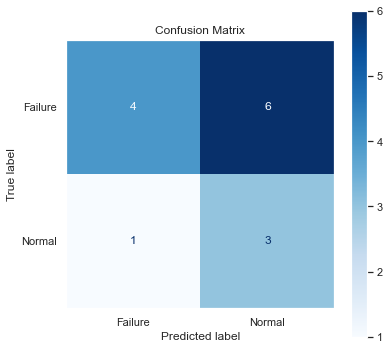

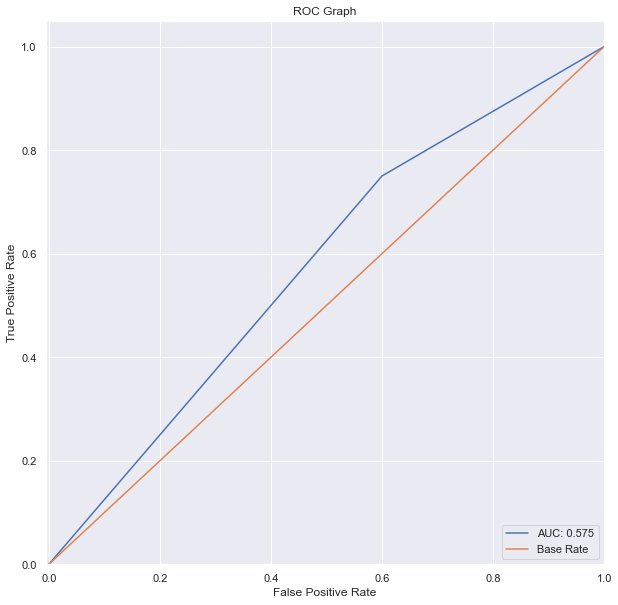

Time to fit best model: 0.002997875213623047 seconds
              precision    recall  f1-score   support

     Failure       0.80      0.40      0.53        10
      Normal       0.33      0.75      0.46         4

    accuracy                           0.50        14
   macro avg       0.57      0.57      0.50        14
weighted avg       0.67      0.50      0.51        14

   accuracy  precision  recall    auc        F1  specificity
0       0.5   0.666667     0.5  0.575  0.512821          0.4

Dataset: LP3
Fitting 1 folds for each of 999 candidates, totalling 999 fits
Best Hyperparameters: 
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



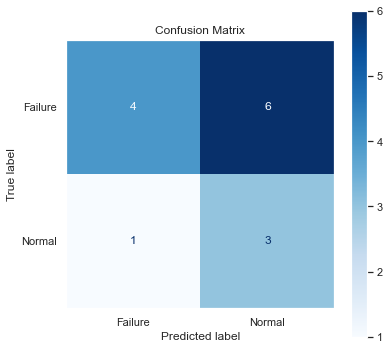

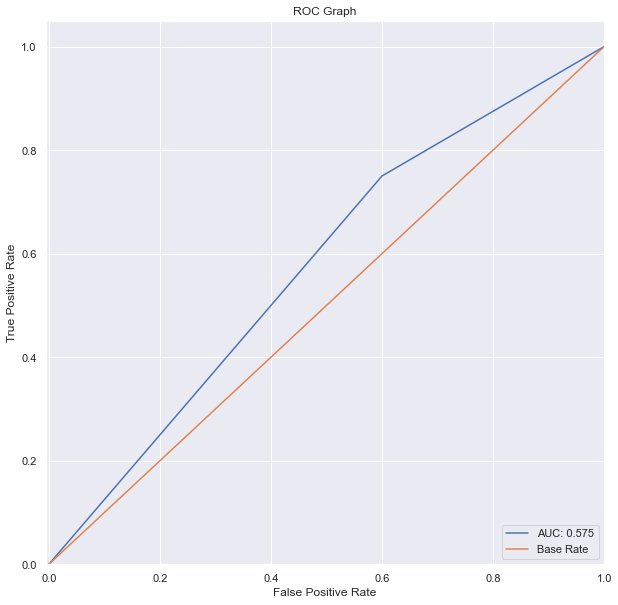

Time to fit best model: 0.0029990673065185547 seconds
              precision    recall  f1-score   support

     Failure       0.80      0.40      0.53        10
      Normal       0.33      0.75      0.46         4

    accuracy                           0.50        14
   macro avg       0.57      0.57      0.50        14
weighted avg       0.67      0.50      0.51        14

   accuracy  precision  recall    auc        F1  specificity
0       0.5   0.666667     0.5  0.575  0.512821          0.4

Dataset: LP4
Fitting 1 folds for each of 999 candidates, totalling 999 fits
Best Hyperparameters: 
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



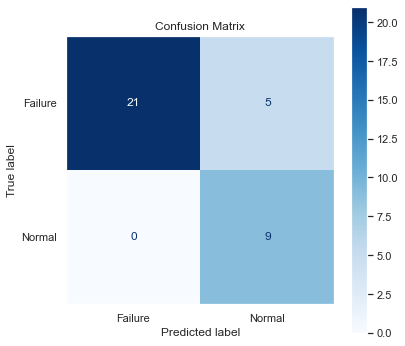

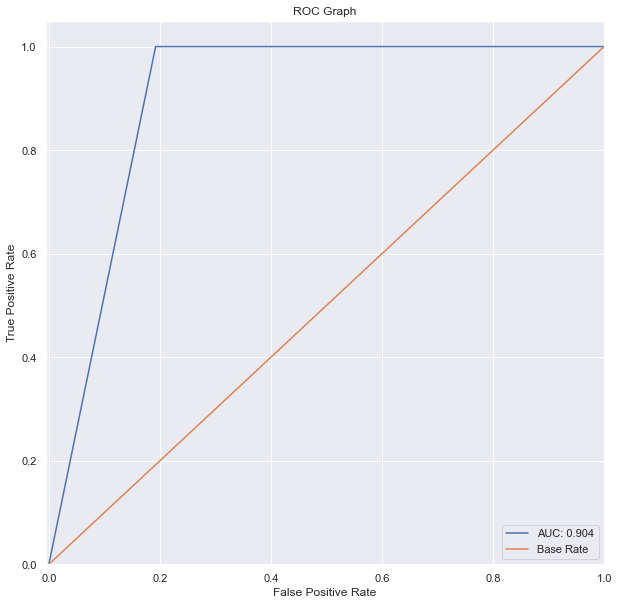

Time to fit best model: 0.003998517990112305 seconds
              precision    recall  f1-score   support

     Failure       1.00      0.81      0.89        26
      Normal       0.64      1.00      0.78         9

    accuracy                           0.86        35
   macro avg       0.82      0.90      0.84        35
weighted avg       0.91      0.86      0.87        35

   accuracy  precision    recall       auc        F1  specificity
0  0.857143   0.908163  0.857143  0.903846  0.865072     0.807692

Dataset: LP5
Fitting 1 folds for each of 999 candidates, totalling 999 fits
Best Hyperparameters: 
{'C': 0.1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



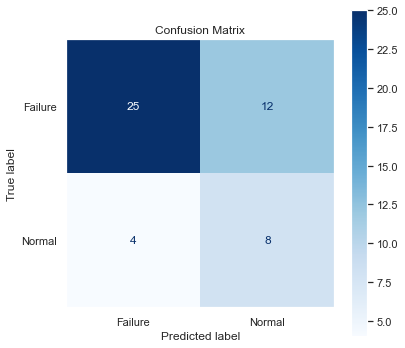

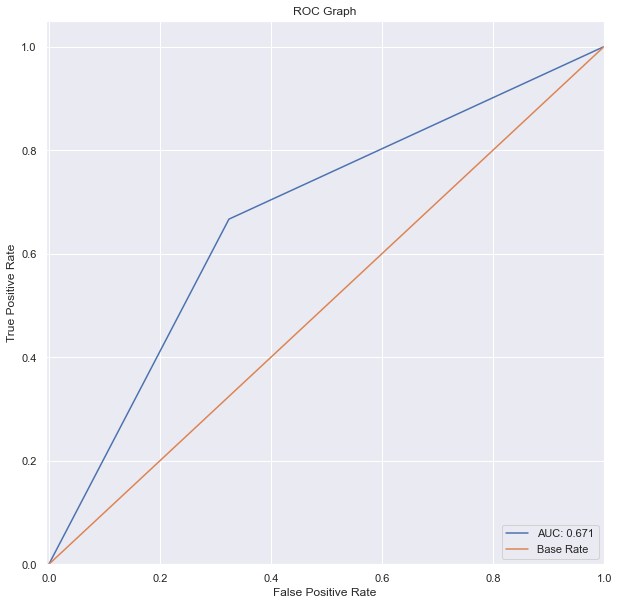

Time to fit best model: 0.013996124267578125 seconds
              precision    recall  f1-score   support

     Failure       0.86      0.68      0.76        37
      Normal       0.40      0.67      0.50        12

    accuracy                           0.67        49
   macro avg       0.63      0.67      0.63        49
weighted avg       0.75      0.67      0.69        49

   accuracy  precision    recall       auc        F1  specificity
0  0.673469   0.748909  0.673469  0.671171  0.694496     0.675676



In [36]:
for dataset, input_cols, output_cols, name in binary_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        # The dataset to be used
        df=dataset,
        # The classifier to be used
        classifier=SVC(kernel='linear'),
        # The hyperparameters to be used
        hyperparams=params,
        # Amount of K Cross-folds to use, 
        # if cv=1 no folds are used
        cv=1,
        # Boolean, should SMOTE be used, default True
        smote=True,
        # Defining the size of the test dataset
        test_size=0.3,
        # Number of iterations to determine best params
        n_iter=1000,
        # Input columns to be used
        input_cols=input_cols,
        # Output columns to be used
        output_cols=output_cols,
        # Boolean, should verbose be used, default True
        verbose=True
    )
    print('=' * 125)

### Discussion

The SVM using a Linear kernel performed relatively poorly, with exceptions on LP1 & LP4 (81.48% and 85.71% respectively). For LP2-3 it achieved an accuracy of only 50%, it is expected that it would perform the worst on these datasets as they have the smallest sample size however these results are extremely underwhelming.

Compared to the SVM - RBF Kernel shown below there is no advantage of using the Linear kernel, as such it would not be suggested to use this model for this application.

---
## SVM - RBF Kernel

In [37]:
# Setting hyperparameters
params = {
    # Regularization parameter
    'C': np.arange(0, 100, 0.1),
    # Kernel coefficient
    'gamma': [
        0.0001, 0.0002, 0.0005, 0.0008,
        0.001, 0.002, 0.005, 0.008,
        0.01, 0.02, 0.05, 0.08,
        0.1, 0.2, 0.5, 0.8,
        1, 2, 5, 8,
        10, 20, 50, 80, 100
    ]
}

Dataset: LP1
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'C': 89.5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0008, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



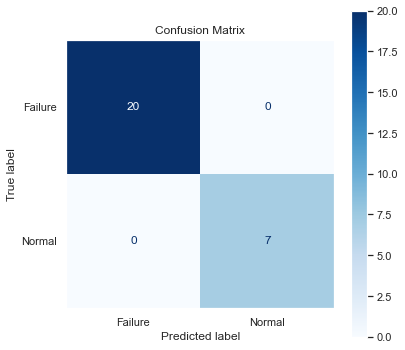

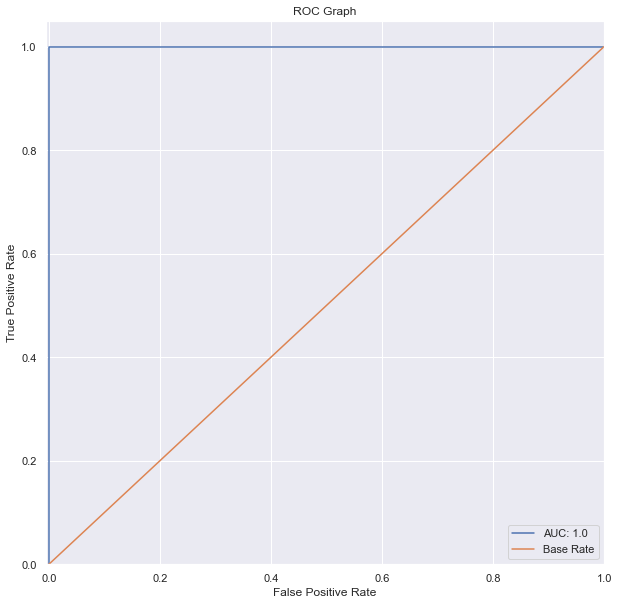

Time to fit best model: 0.0029993057250976562 seconds
              precision    recall  f1-score   support

     Failure       1.00      1.00      1.00        20
      Normal       1.00      1.00      1.00         7

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

   accuracy  precision  recall  auc   F1  specificity
0       1.0        1.0     1.0  1.0  1.0          1.0

Dataset: LP2
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'C': 89.5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0008, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



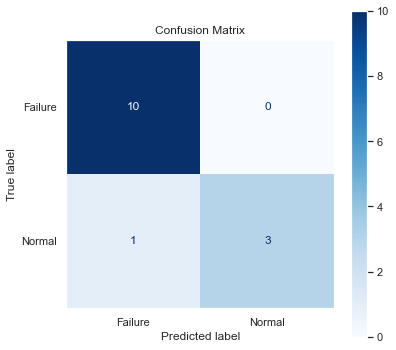

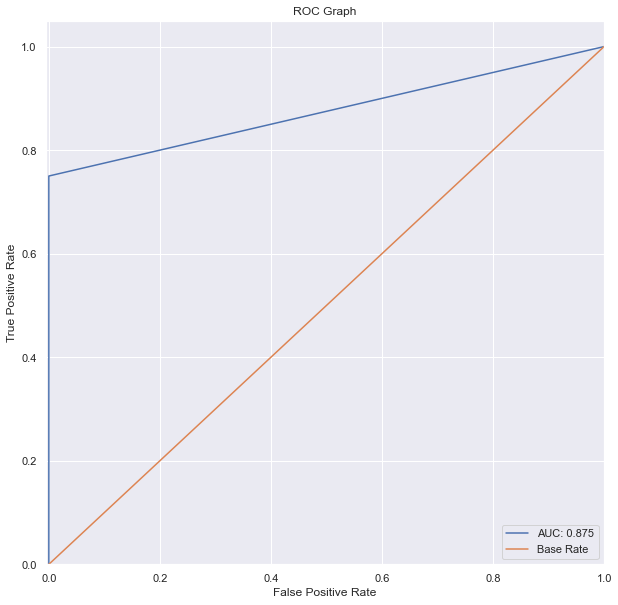

Time to fit best model: 0.0029985904693603516 seconds
              precision    recall  f1-score   support

     Failure       0.91      1.00      0.95        10
      Normal       1.00      0.75      0.86         4

    accuracy                           0.93        14
   macro avg       0.95      0.88      0.90        14
weighted avg       0.94      0.93      0.93        14

   accuracy  precision    recall    auc       F1  specificity
0  0.928571   0.935065  0.928571  0.875  0.92517          1.0

Dataset: LP3
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'C': 89.5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0008, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



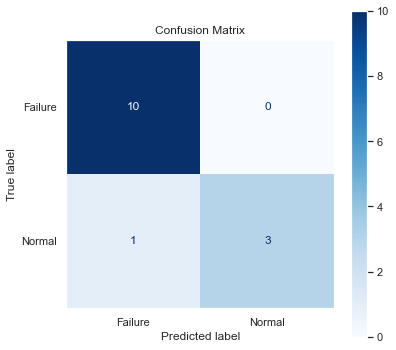

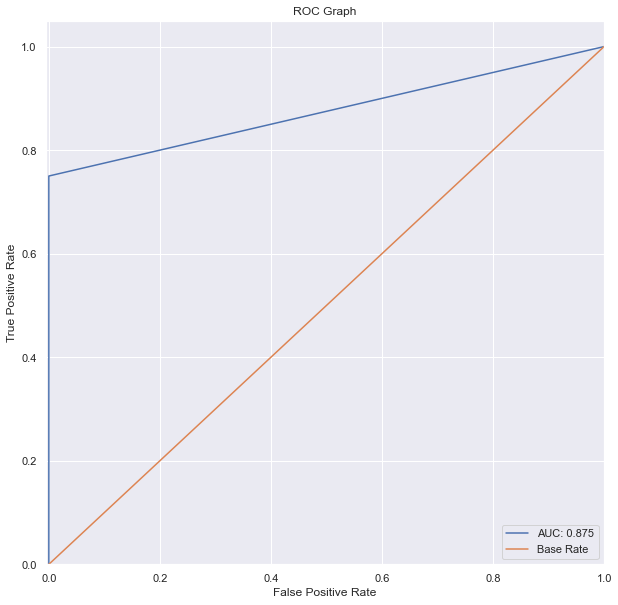

Time to fit best model: 0.00299835205078125 seconds
              precision    recall  f1-score   support

     Failure       0.91      1.00      0.95        10
      Normal       1.00      0.75      0.86         4

    accuracy                           0.93        14
   macro avg       0.95      0.88      0.90        14
weighted avg       0.94      0.93      0.93        14

   accuracy  precision    recall    auc       F1  specificity
0  0.928571   0.935065  0.928571  0.875  0.92517          1.0

Dataset: LP4
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'C': 89.5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0008, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



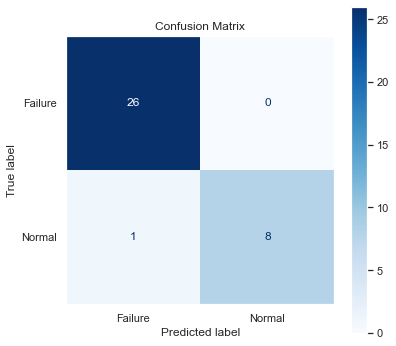

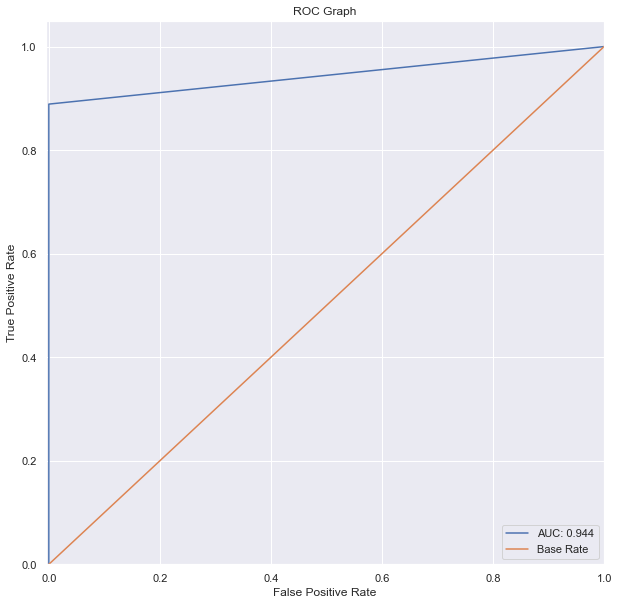

Time to fit best model: 0.003998756408691406 seconds
              precision    recall  f1-score   support

     Failure       0.96      1.00      0.98        26
      Normal       1.00      0.89      0.94         9

    accuracy                           0.97        35
   macro avg       0.98      0.94      0.96        35
weighted avg       0.97      0.97      0.97        35

   accuracy  precision    recall       auc        F1  specificity
0  0.971429   0.972487  0.971429  0.944444  0.970858          1.0

Dataset: LP5
Fitting 1 folds for each of 1000 candidates, totalling 1000 fits
Best Hyperparameters: 
{'C': 89.5, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0008, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}



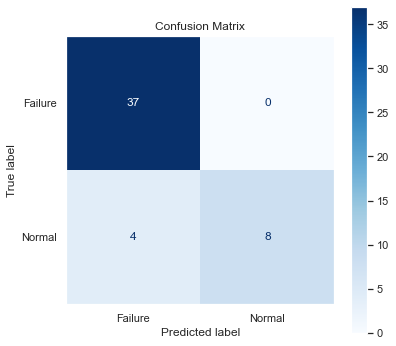

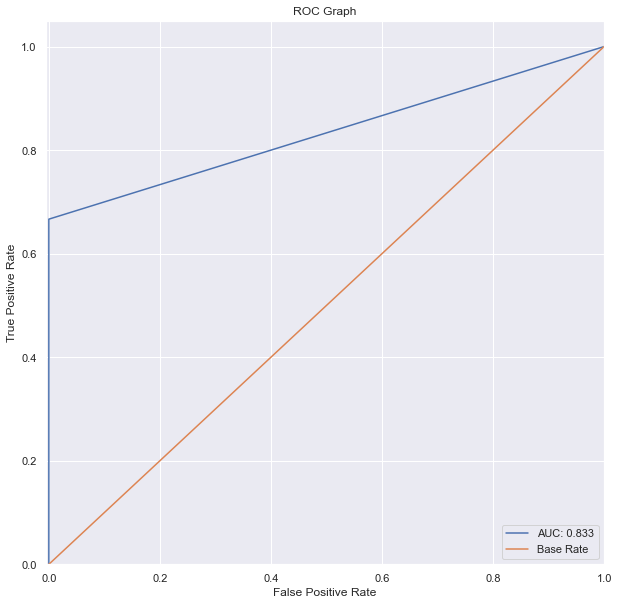

Time to fit best model: 0.005997657775878906 seconds
              precision    recall  f1-score   support

     Failure       0.90      1.00      0.95        37
      Normal       1.00      0.67      0.80        12

    accuracy                           0.92        49
   macro avg       0.95      0.83      0.87        49
weighted avg       0.93      0.92      0.91        49

   accuracy  precision    recall       auc        F1  specificity
0  0.918367   0.926332  0.918367  0.833333  0.912297          1.0



In [38]:
for dataset, input_cols, output_cols, name in binary_zipped_dict:
    print(f'Dataset: {name}')
    build_model(
        # The dataset to be used
        df=dataset,
        # The classifier to be used
        classifier=SVC(kernel='rbf'),
        # The hyperparameters to be used
        hyperparams=params,
        # Amount of K Cross-folds to use, 
        # if cv=1 no folds are used
        cv=1,
        # Boolean, should SMOTE be used, default True
        smote=True,
        # Defining the size of the test dataset
        test_size=0.3,
        # Number of iterations to determine best params
        n_iter=1000,
        # Input columns to be used
        input_cols=input_cols,
        # Output columns to be used
        output_cols=output_cols,
        # Boolean, should verbose be used, default True
        verbose=True
    )
    print('=' * 125)

### Discussion

The SVM using an RBF kernel performed extremely well on all datasets, with the lowest accuracy being 91.84% on LP5. It also was able to fit the model extremely quickly which is advantageous. These would suggest that the SVM with RBF kernel would be the best model for this application.

Although from the results that have been produced this is true, since the datasets are so small there cannot be great confidence given to the results produced from the models. In an ideal scenario, the datasets would be re-made with fewer class imbalances and with a much larger sample size.

---
## Artificial Neural Network - Feed Forward

LP1


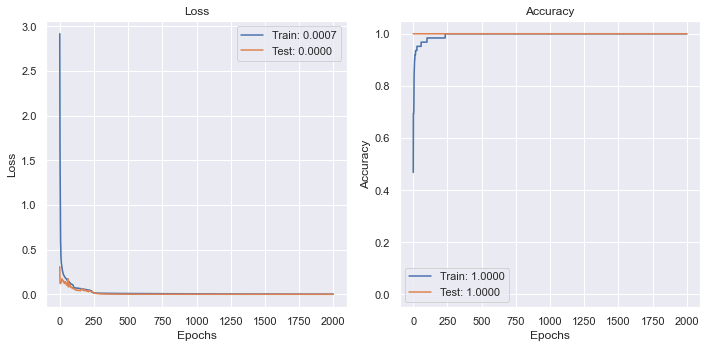

Time to Train model: 96.18048405647278 seconds
LP1 Test Loss: 1.215
LP1 Test Accuracy: 0.889

LP2


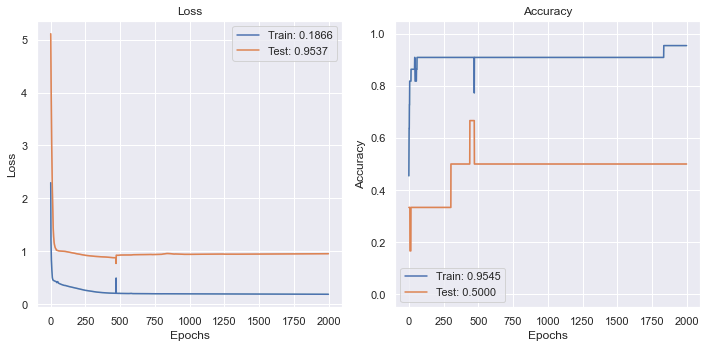

Time to Train model: 96.5451169013977 seconds
LP2 Test Loss: 0.793
LP2 Test Accuracy: 0.632

LP3


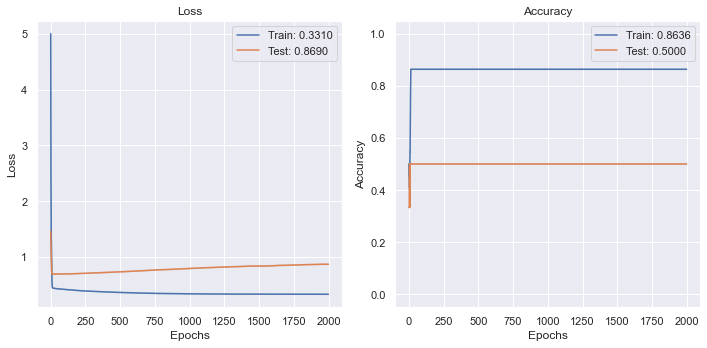

Time to Train model: 99.75734567642212 seconds
LP3 Test Loss: 0.654
LP3 Test Accuracy: 0.632

LP4


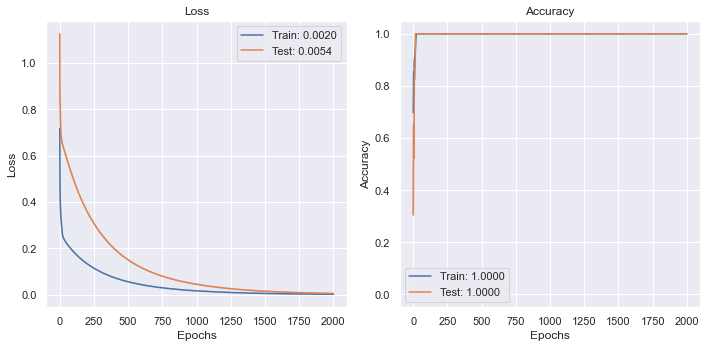

Time to Train model: 102.37991547584534 seconds
LP4 Test Loss: 0.052
LP4 Test Accuracy: 0.979

LP5


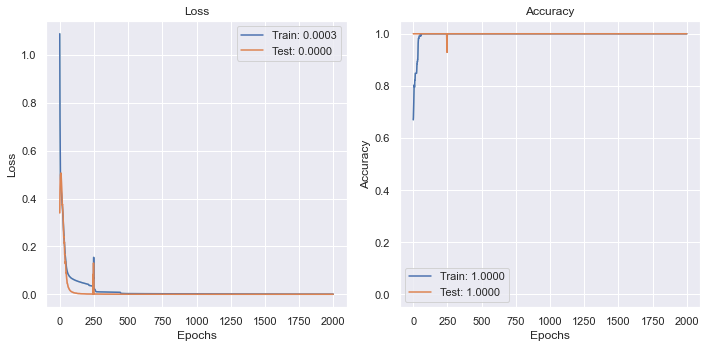

Time to Train model: 102.7696886062622 seconds
LP5 Test Loss: 2.605
LP5 Test Accuracy: 0.894



In [47]:
for dataset, input_cols, output_cols, names in binary_zipped_dict:
    
    df_model = dataset.copy()
    
    #
    X = df_model[input_cols].copy()
    #
    y = df_model[output_cols].copy()
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    
    # SMOTE
    sm = SMOTE(
            random_state=0,
            k_neighbors=1
        )
    # Applying SMOTE to training dataset
    X_train, y_train = sm.fit_resample(
        X_train,
        y_train.values
    )
    
    n_features = X_train.shape[1]
    
    # Creating the model
    model = Sequential()

    # Adding Dense layers of nodes to the model
    model.add(Dense(10, activation='relu', input_shape=(n_features,)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the model, using accuracy as the metric to optimise
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Setting time training started
    t1 = time.time()
    
    # Fitting the model to the train dataset
    history = model.fit(
        X_train, y_train,
        epochs=2000,
        batch_size=20,
        validation_split=0.2,
        verbose=0
    ).history
    
    # Setting time training ended
    t2 = time.time()
    
    # Printing Dataset name
    print(f'{names}')
    
    # Plotting graphs of loss & accuracy against Epochs
    plot_history(history)
    plt.show()
    
    # Printing time for model to train
    print(f'Time to Train model: {t2 - t1} seconds')
    
    # Calculating loss and accuracy on test dataset
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f'{names} Test Loss: %.3f' % loss)
    print(f'{names} Test Accuracy: %.3f' % acc)
    print('')
    print('=' * 125)

### Discussion

The Neural Network performs well for LP1, LP4 & LP5. The accuracy results for LP2 & LP3 are very low, although this is to be expected when trying to train a neural network on less than 50 datapoints.

With more time, the amount of layers in the neural network could be varied to optimise the model further, although due to the dataset sizes, traditional ML methods (namely decision trees) would be expected to perform better.

---
---
# Results

Results will be discussed in detail in the **report**.